# Prática: Potenciais extracelulares do micro ao macro (EEG)

Na primeira parte desta aula, nós exploramos como são gerados os sinais extracelulares do tipo potencial de campo local. Agora vamos explorar como são gerados os sinais de EEG e quais as diferenças entre os sinais de LFP e de EEG. 

<img src="registro_escalas.jpg"/>

**Figura 1.** Registros dos potenciais extracelulares em diferentes escalas (imagem extraída de https://www.frontiersin.org/articles/10.3389/fninf.2018.00092/full)

A expansão de multipolos para potenciais distribuídos aleatoriamente é determinada por:

$$ \begin{aligned} \phi(\mathbf{r}) & =\frac{1}{4 \pi \sigma} \sum_{n=1}^N \frac{I_n}{\left|\mathbf{r}-\mathbf{r}_n\right|} d \mathbf{r} \\ & \equiv \sum_{m=1}^{\infty} \phi_m \\ \phi_1 & =\frac{\sum_{n=1}^N I_n}{4 \pi \sigma r}, \phi_2=\frac{\mathbf{p} \cdot \mathbf{r}}{4 \pi \sigma r^3} \\ \phi_3 & \propto \frac{1}{r^3}, \phi_4 \propto \frac{1}{r^4}, \ldots \end{aligned} $$

em que o dipolo de corrente é determinado por: $\mathbf{p}=\sum_{n=1}^N I_n \mathbf{r}_n$. 

Para os cálculos da propagação do potencial extracelular, devemos ter em mente duas coisas:

* Consideramos os neurônios como circuitos elétricos fechados, de modo que não produzimos monopolos.
* Podemos ignorar multipolos acima de quadropolos.

**Para pensar:**
1) Com base no que fizemos na atividade de potenciais extracelulares, você consegue levantar uma hipótese do porque podemos desconsiderar termos de ordem mais alta que $r^4$?

Para um meio infinito e homogêneo, temos:
$$
\begin{equation}
V = \frac{\mathbf{p \cdot r}}{4 \pi \sigma r^3}
\end{equation}
$$

No entanto, a cabeça não é um meio condutor com propriedades homogêneas. Pensando nisso, um modelo condutor de quatro-esferas foi proposto por [Naess et al. 2017](https://www.frontiersin.org/articles/10.3389/fnhum.2017.00490/full). Neste modelo, o sinal de EEG é estimado considerando a propagação por quatro meios com $\sigma$ diferentes. 

<img src="four_sphere.png"/>

Nós sabemos, no entanto que a cabeça não é formada por quatro esferas perfeitas. Por isso, pode ser interessante utilizada dados anatômicos para verificar tanto o formato da cabeça, quanto a espessura das camadas corticais. Aqui, vamos utilizar uma cabeça padrão (ou média), mas este tipo de simulação pode ser aplicada a dados anatômicos (MRI). 

A pergunta que não quer calar é, o quão boa é a simplificação do modelo de quatro esferas?

<img src="comparison_head_model.png"/>

### Tarefa 1: Efeitos da distância e do meio nas curvas de decaimento

1) Compare a variação de potencial considerando o meio infinito e homogêneo e considerando o modelo de quatro esferas.
2) Verifique o que acontece quando nós deslocamos o dipolo de corrente em três casos: (a) quando deslocamos a população seguindo o arco da cabeça, (b) quando variamos a profundidade do dipolo e (c) quando deslocamos o dipolo lateralmente. Repita esta análise para ambos os modelos.
3) O sinal de EEG é robusto a movimentações no dipolo? Explique sua resposta. 

In [4]:
# Importando bibliotecas
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lfpykit.eegmegcalc import FourSphereVolumeConductor
from brainsignals.plotting_convention import mark_subplots, simplify_axes, cmap_v_e

In [5]:
# Definindo a localização da fonte de corrente

head_colors = ["#ffb380", "#74abff", "#b3b3b3", "#c87137"]

radii = [89000., 90000., 95000., 100000.]  # (µm)
sigmas = [0.276, 1.65, 0.01, 0.465]  # (S/m)

cdm_amp = 100
p = np.array([[0.], [0.], [cdm_amp]]) # 1 timestep (nA µm)
dipole_loc = np.array([0., 0., 88000.])  # (µm)

z = np.linspace(dipole_loc[2] + 500, radii[-1] - 1, 500)
x = np.zeros(len(z))
y = np.zeros(len(z))
r_elecs = np.array([x, y, z]).T # (µm)

In [6]:
# Utilidades gráficas

def plot_four_sphere_model(ax, radii, dipole_loc=None, labeltext=True):

    for i in range(4):
        ax.add_patch(plt.Circle((0, 0), radius=radii[-1 - i],
                                   color=head_colors[-1-i],
                                   fill=True, ec='k', lw=.1))
    if not dipole_loc is None:
        ax.arrow(dipole_loc[0], dipole_loc[2] - 1500, 0, 750, 
                 color='k', head_width=500)
    
    if labeltext:
        # mark 4-sphere head model layers
        ax.text(-17500, radii[0] - 4500, 'brain', ha="right", rotation=8)
        ax.text(-17500, radii[1] - 3300, 'CSF', ha="right", rotation=8)
        ax.text(-17500, radii[2] - 4500, 'skull', ha="right", rotation=8)
        ax.text(-17500, radii[3] - 5000, 'scalp', ha="right", rotation=8)

        
def dipole_potential(elec_locs, dipole_pos, p):
    # Potential in infinite homogeneous medium
    r_ = elec_locs.T - dipole_pos
    V_e = 1000 * 1. / (4 * np.pi * sigmas[0]) * (np.dot(r_, p.T)
                    / np.linalg.norm(r_, axis=1) ** 3)
    return V_e
        

In [7]:
sphere_model = FourSphereVolumeConductor(r_elecs, radii, sigmas)
M = sphere_model.get_transformation_matrix(dipole_loc)  
pot_4s_decay = 1000 * M @ p # (uV)

# Compare with potential from dipole in infinite homogeneous medium
pot_homog_decay = dipole_potential(r_elecs.T, dipole_loc, p[:, 0])

In [8]:
# Definindo posição dos eletrodos de registro (onde será calculado o EEG)

xlim = [-17000, 17000]
zlim = [dipole_loc[2] + 100, radii[-1] - 1]

# Many point will give long computation times
num_angles = 61
num_heights_eeg = 50

max_angle = np.abs(np.rad2deg(np.arcsin(xlim[0] / zlim[0])))
angle = np.linspace(-max_angle, max_angle, num_angles)

x_eeg = np.zeros((num_heights_eeg, num_angles))
z_eeg = np.zeros((num_heights_eeg, num_angles))

for r_idx, r in enumerate(np.linspace(zlim[0], zlim[1], num_heights_eeg)):
    x_ = r * np.sin(np.deg2rad(angle))
    z_ = r * np.cos(np.deg2rad(angle))
    x_eeg[r_idx, :] = x_
    z_eeg[r_idx, :] = z_

y_eeg = np.zeros(x_eeg.shape)
r_elecs_grid = np.array([x_eeg.flatten(), y_eeg.flatten(), z_eeg.flatten()]).T

pot_homog = dipole_potential(r_elecs_grid.T, dipole_loc, p[:, 0])

four_sphere = FourSphereVolumeConductor(r_elecs_grid, radii, sigmas)
M = four_sphere.get_transformation_matrix(dipole_loc)  
pot_four_sphere = 1000 * M @ p # (uV)

In [9]:
num_pops = 100
phi = np.linspace(0, np.pi / 3, num_pops)
dipole_radial_dist = dipole_loc[2]
pop_ys = np.zeros(num_pops)
pop_xs = dipole_radial_dist * np.sin(phi)
pop_zs = dipole_radial_dist * np.cos(phi)

num_elecs = len(z_)
Fs_4s = np.zeros(num_pops)
Fs_ih = np.zeros(num_pops)
sphere_model_ = FourSphereVolumeConductor(r_elecs[-1:,:], radii, sigmas)
for p_idx in range(num_pops):

    dipole_loc_ = np.array([pop_xs[p_idx], 
                           pop_ys[p_idx], 
                           pop_zs[p_idx]])
    radial_vec = dipole_loc_ / np.linalg.norm(dipole_loc_)
    
    M = sphere_model_.get_transformation_matrix(dipole_loc_)
    Fs_4s[p_idx] = 1000 * M @ radial_vec * cdm_amp
    Fs_ih[p_idx] = dipole_potential(r_elecs[-1:,:].T, dipole_loc_, radial_vec * cdm_amp)

/tmp/ipykernel_28300/2371982631.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Fs_4s[p_idx] = 1000 * M @ radial_vec * cdm_amp
/tmp/ipykernel_28300/2371982631.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Fs_ih[p_idx] = dipole_potential(r_elecs[-1:,:].T, dipole_loc_, radial_vec * cdm_amp)


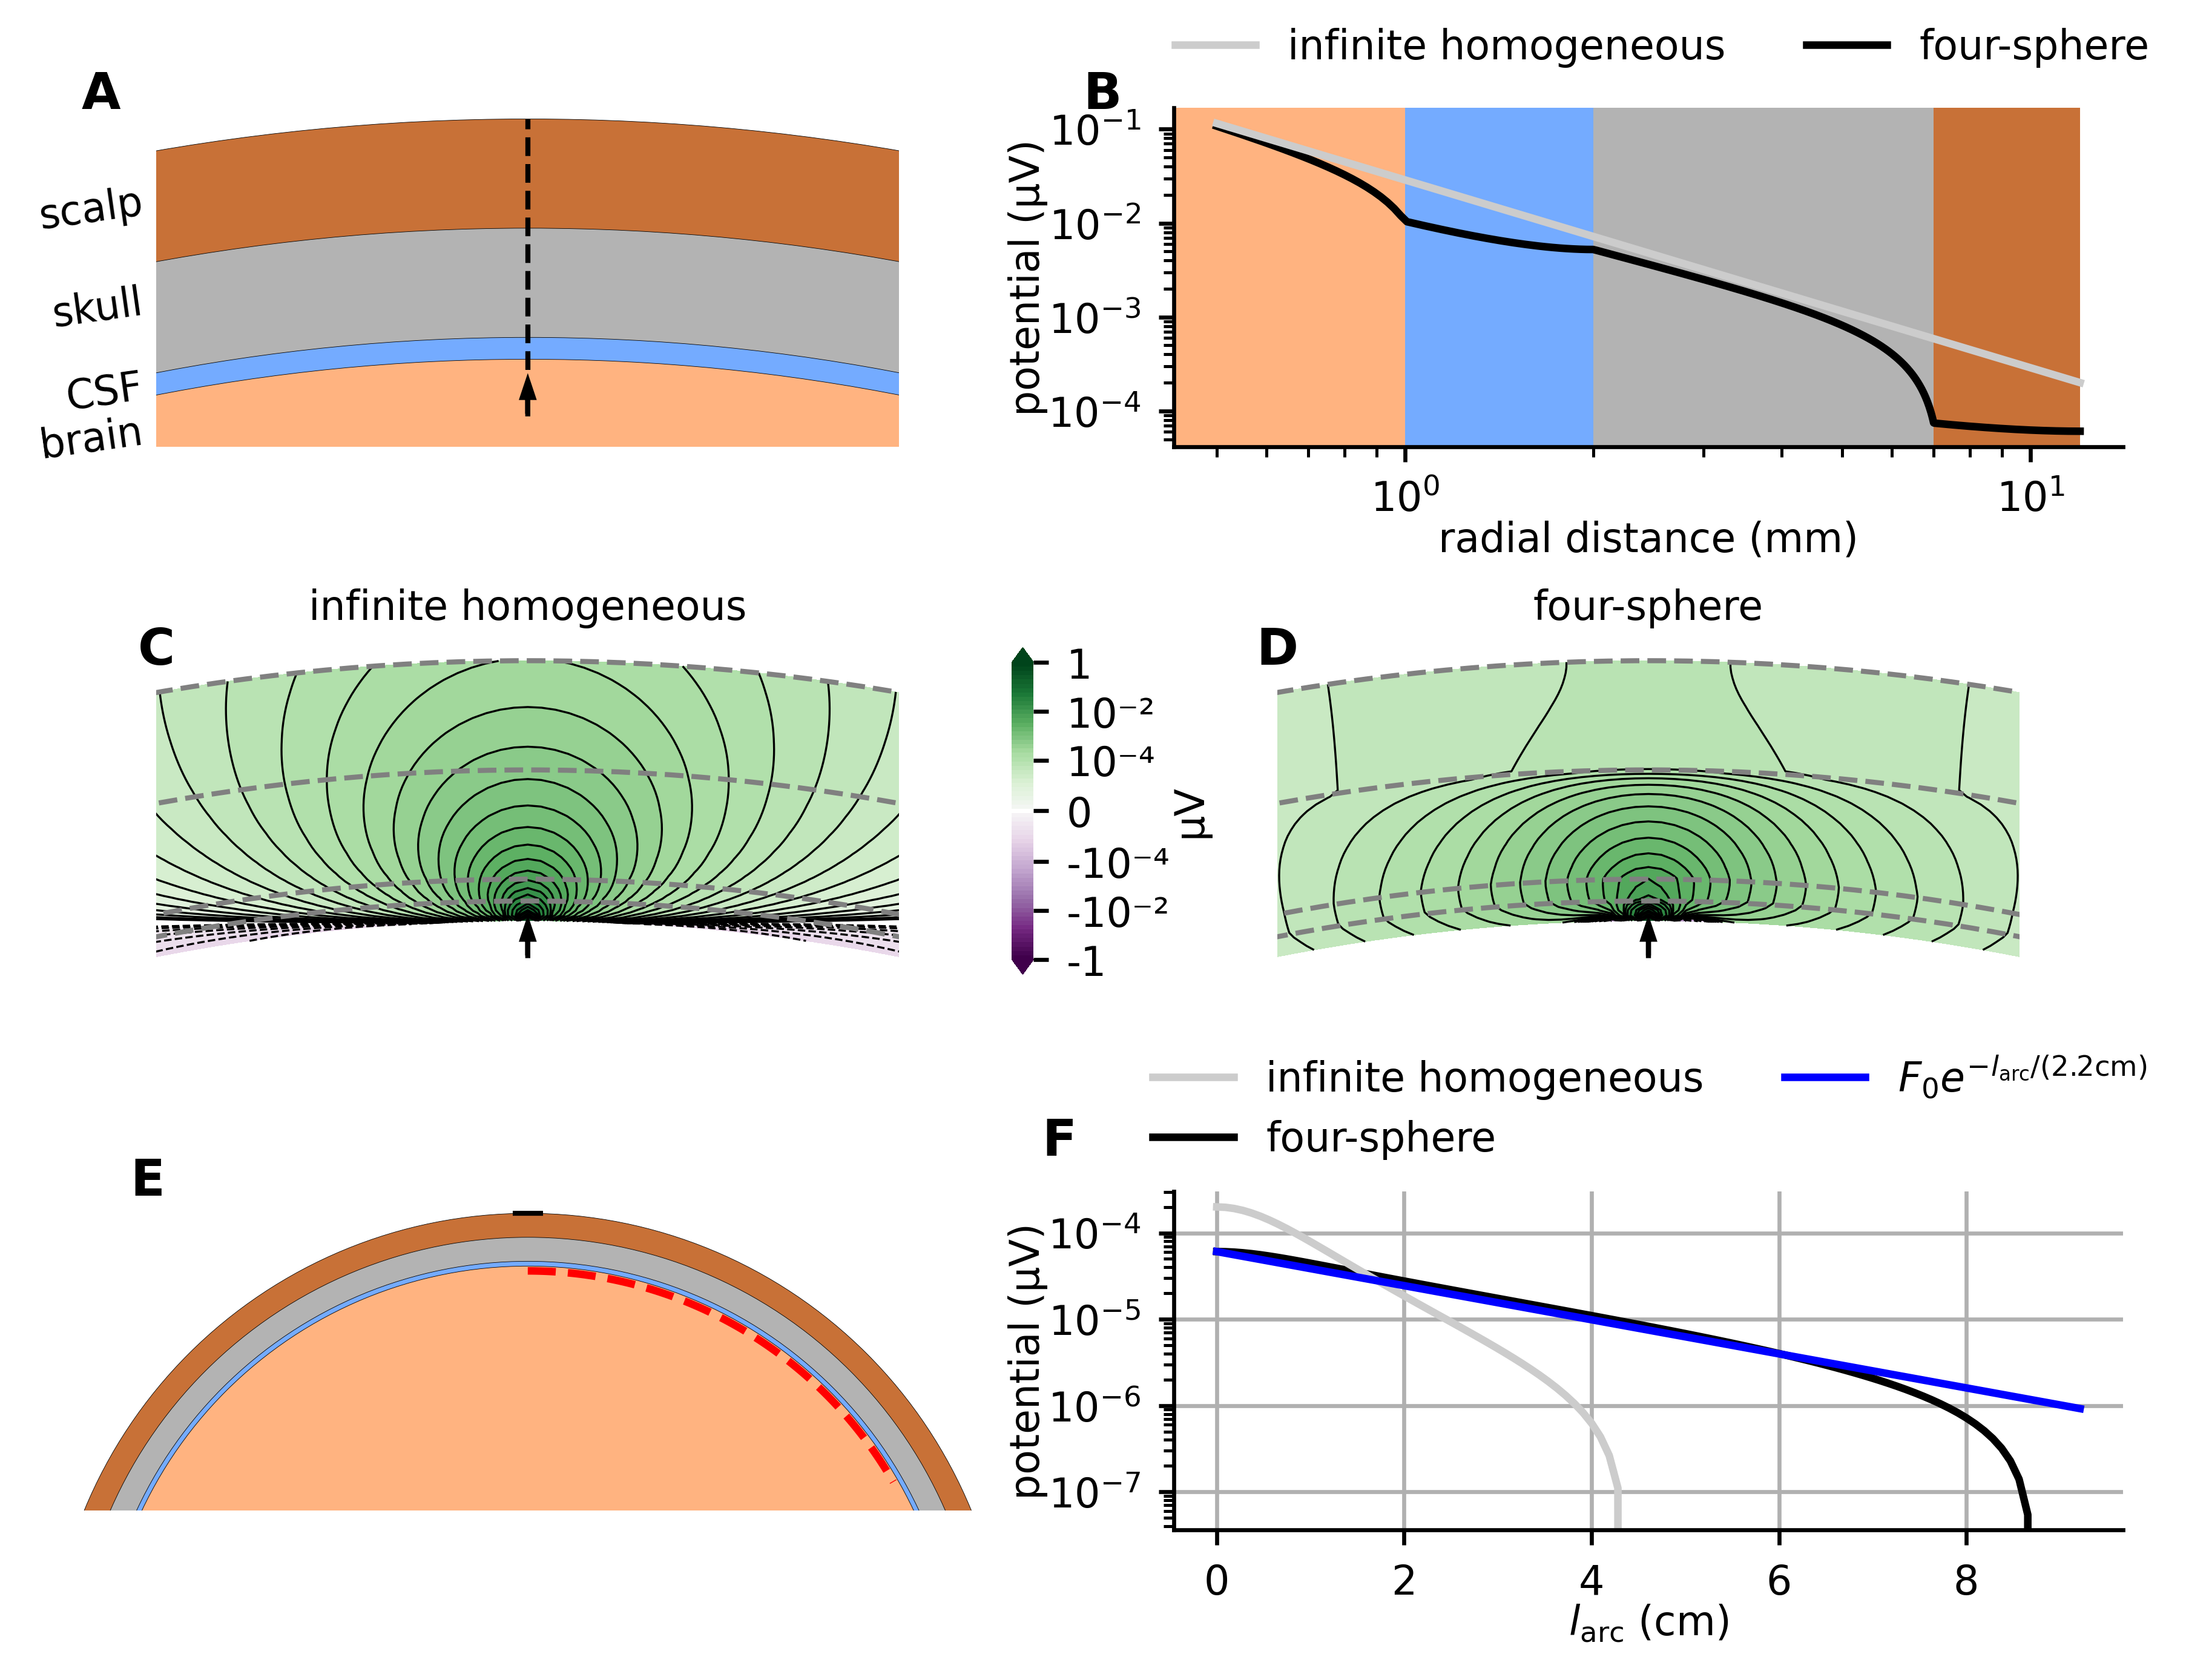

In [10]:
ylim = [dipole_loc[2] - 3000, radii[-1] + 500]

fig = plt.figure(figsize=[6, 4.5])
fig.subplots_adjust(bottom=0.08, right=0.98, left=0.03, top=0.95, 
                    wspace=.18, hspace=0.6)
ax_geom = fig.add_subplot(321, frameon=False, aspect=1,
                         xticks=[], yticks=[],
                         xlim=[-17000, 17000],
                         ylim=ylim)
ax_pot = fig.add_subplot(322, xlabel="radial distance (mm)", ylabel="potential (µV)")

plot_four_sphere_model(ax_geom, radii, dipole_loc)
ax_geom.plot(x, z, '--', lw=1, c='k')

l1, = ax_pot.loglog((z - dipole_loc[2]) / 1000, pot_4s_decay[:, 0], c='k')
l3, = ax_pot.loglog((z - dipole_loc[2]) / 1000, pot_homog_decay, c='0.8')

layer_dist_from_neuron = [(r - dipole_loc[2])*1e-3 for r in radii]
for ax in [ax_pot]:
    ax.axvspan(0, layer_dist_from_neuron[0], facecolor=head_colors[0])
    ax.axvspan(layer_dist_from_neuron[0], layer_dist_from_neuron[1], facecolor=head_colors[1])
    ax.axvspan(layer_dist_from_neuron[1], layer_dist_from_neuron[2], facecolor=head_colors[2])
    ax.axvspan(layer_dist_from_neuron[2], layer_dist_from_neuron[3], facecolor=head_colors[3])

fig.legend([l3, l1], ["infinite homogeneous", "four-sphere", ], 
           frameon=False, ncol=2, loc=(0.53, 0.95))
simplify_axes(ax_pot)
mark_subplots(fig.axes, ypos=1.04, xpos=-0.075)


num = 35
levels = np.logspace(-6, 0, num=num)
scale_max = 1#10**np.ceil(np.log10(np.max(np.abs(pot_homog))))
levels_norm = scale_max * np.concatenate((-levels[::-1], levels))

colors_from_map = [cmap_v_e(i/(len(levels_norm) - 2)) 
                   for i in range(len(levels_norm) - 1)]

colors_from_map[num - 1] = (1.0, 1.0, 1.0, 1.0)

pot_homog = pot_homog.reshape(x_eeg.shape)
pot_foursphere = pot_four_sphere.reshape(x_eeg.shape)

ax_homog = plt.subplot(323, aspect=1, xlim=xlim, ylim=ylim, 
                       title="infinite homogeneous",
                       frameon=False, xticks=[], yticks=[])

ax_foursphere = plt.subplot(324, aspect=1, xlim=xlim, ylim=ylim, 
                            title="four-sphere", 
                            frameon=False, xticks=[], yticks=[])

axes = [ax_homog, ax_foursphere]
pots = [pot_homog, pot_foursphere]

for i in range(len(axes)):
    ax = axes[i]
    pot = pots[i]
    for i in range(4):
        ax.add_patch(plt.Circle((0, 0), radius=radii[i], ls="--",
                                   fill=False, ec='gray', lw=1.))

    ax.arrow(dipole_loc[0], dipole_loc[2] - 1500, 0, 750,
                 color='k', head_width=500)
    
    img = ax.contourf(x_eeg, z_eeg, pot,
                               zorder=-2, colors=colors_from_map,
                               levels=levels_norm, extend='both')

    ax.contour(x_eeg, z_eeg, pot, linewidths = 0.4,
               colors='k', zorder = -2,
               levels=levels_norm)

cax = fig.add_axes([0.47, 0.42, 0.01, 0.2], frameon=False)
cbar = fig.colorbar(img, cax=cax,
            #orientation='horizontal', 
                    label="µV")#format='%3.3f',)

ticks = [-1e0, -1e-2, -1e-4, 0, 1e-4, 1e-2, 1e0]
ticklabels = ["-1", "-10⁻²","-10⁻⁴", "0", "10⁻⁴", "10⁻²", "1"]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)

mark_subplots(axes, "CD", xpos=.0, ypos=1.0)

ylim_ = [dipole_loc[2] - 50000, radii[-1] + 500]
xlim_ = [-99000, 99000]
ax_geom = fig.add_subplot(325, frameon=False, aspect=1,
                         xticks=[], yticks=[],
                         xlim=xlim_,
                         ylim=ylim_)

ax_pot = fig.add_subplot(326,
                         xlabel=r"$l_{\rm arc}$ (cm)", 
                         ylabel="potential (µV)")

plot_four_sphere_model(ax_geom, radii, labeltext=False)

ax_geom.plot(x[-1], z[-1], '_', c='k')
ax_geom.plot(pop_xs, pop_zs, 'r--')


l1, = ax_pot.semilogy(dipole_radial_dist * phi * 1e-4, Fs_4s, c='k')
l2, = ax_pot.semilogy(dipole_radial_dist * phi * 1e-4, Fs_ih, c='0.8')

x_lambda = 2.2
x_ = dipole_radial_dist * phi * 1e-4
y_ = Fs_4s[0] * np.exp(-x_**1 / x_lambda)
l0, = ax_pot.plot(x_, y_, c='b')

mark_subplots([ax_geom], ["E"], xpos=0.1, ypos=1.1)
mark_subplots([ax_pot], ["F"])

ax_pot.grid(True)

fig.legend([l2, l1, l0], ["infinite homogeneous", 
                          "four-sphere", 
                          r"$F_0 e^{-l_{\rm arc}/(2.2{\rm cm})}$"], 
           frameon=False, ncol=2, loc=(0.52, 0.3))

simplify_axes(ax_pot)
plt.savefig("pot_decay_head.pdf")

In [11]:
from matplotlib.patches import Ellipse

#head_colors = ["#ffb380", "#74abff", "#b3b3b3", "#c87137"]

human_cortex_thickness = 3 * 1e3  # 3 mm
r_elecs = np.array([[0, 0, radii[-1] - 1]]) # (µm)

dipole_depths = np.linspace(radii[0] - human_cortex_thickness, radii[0] - 100, 50)
lateral_x_shifts = np.linspace(0, 5000, 50)

default_depth_idx = np.argmin(np.abs(dipole_depths - (radii[0] - 1500)))
default_depth = dipole_depths[default_depth_idx]

def plot_four_sphere_model(ax, radii, dipole_loc=None):
    
    for i in range(4):
        ax.add_patch(plt.Circle((0, 0), radius=radii[-1 - i],
                                   color=head_colors[-1-i],
                                   fill=True, ec='k', lw=.1))
    if not dipole_loc is None:
        ax.plot(dipole_loc[0], dipole_loc[2], 'r.')
        
    # mark 4-sphere head model layers
    ax.text(-10500, radii[0] - 3500, 'brain', ha="right", rotation=4)
    ax.text(-10500, radii[1] - 2200, 'CSF', ha="right", rotation=4)
    ax.text(-10500, radii[2] - 4000, 'skull', ha="right", rotation=4)
    ax.text(-10500, radii[3] - 4000, 'scalp', ha="right", rotation=4)

        
def dipole_potential(elec_locs, dipole_pos, p):
    # Potential in infinite homogeneous medium
    r_ = elec_locs.T - dipole_pos
    V_e = 1000 * 1. / (4 * np.pi * sigmas[0]) * (np.dot(r_, p.T)
                    / np.linalg.norm(r_, axis=1) ** 3)
    return V_e
        

In [12]:
depths_eeg_4s = np.zeros(len(dipole_depths))
depths_eeg_homog = np.zeros(len(dipole_depths))

lat_eeg_4s = np.zeros(len(lateral_x_shifts))
lat_eeg_homog = np.zeros(len(lateral_x_shifts))

sphere_model = FourSphereVolumeConductor(r_elecs, radii, sigmas)
for di, depth in enumerate(dipole_depths):
    dipole_loc = np.array([0., 0., depth])
    M = sphere_model.get_transformation_matrix(dipole_loc)  
    pot = 1e3 * M @ p # (uV)
    # Compare with potential from dipole in infinite homogeneous medium
    pot_homog = dipole_potential(r_elecs.T, dipole_loc, p[:, 0])
    
    depths_eeg_4s[di] = pot
    depths_eeg_homog[di] = pot_homog
    
for xi, lat_pos in enumerate(lateral_x_shifts):
    dipole_loc = np.array([lat_pos, 0., default_depth])
    M = sphere_model.get_transformation_matrix(dipole_loc)  
    pot = 1e3 * M @ p # (uV)
    # Compare with potential from dipole in infinite homogeneous medium
    pot_homog = dipole_potential(r_elecs.T, dipole_loc, p[:, 0])
    
    lat_eeg_4s[xi] = pot
    lat_eeg_homog[xi] = pot_homog


/tmp/ipykernel_28300/1465171919.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  depths_eeg_4s[di] = pot
/tmp/ipykernel_28300/1465171919.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  depths_eeg_homog[di] = pot_homog
/tmp/ipykernel_28300/1465171919.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat_eeg_4s[xi] = pot
/tmp/ipykernel_28300/1465171919.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

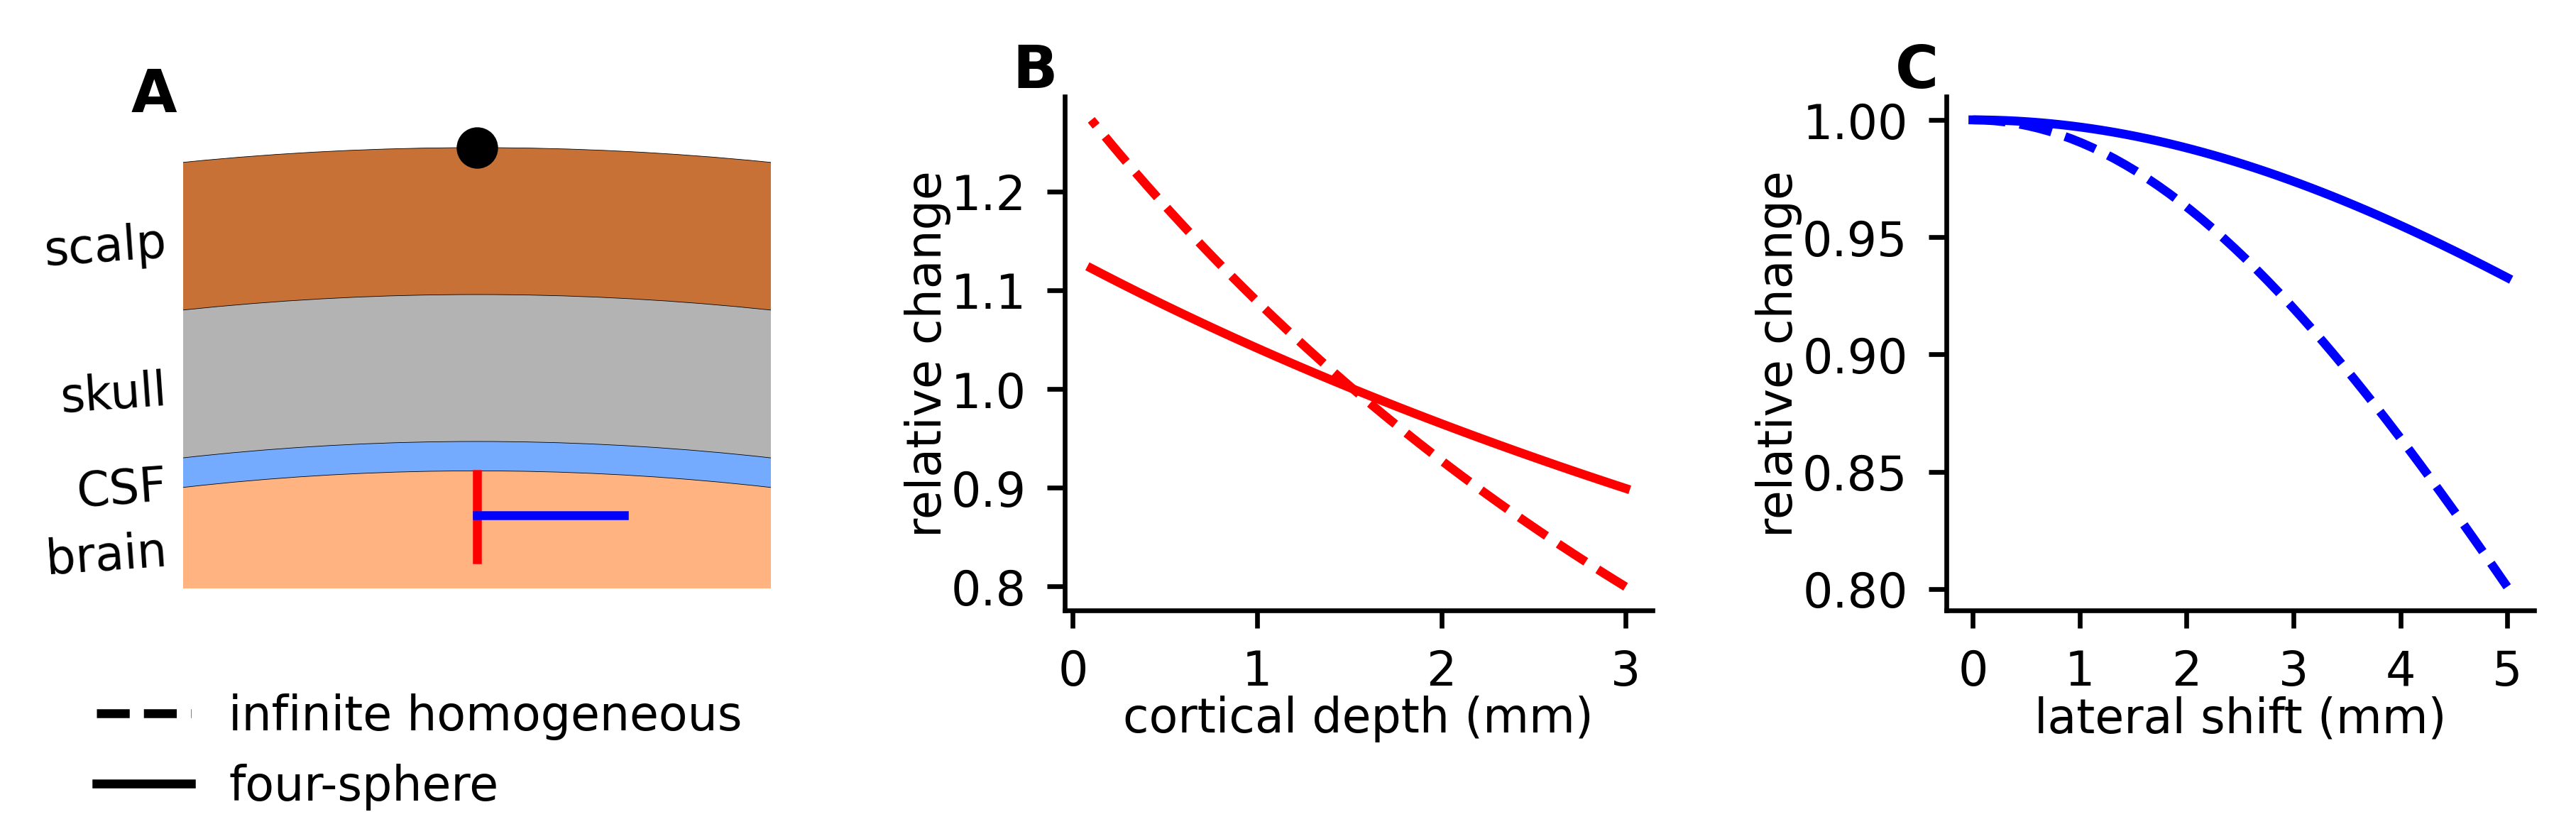

In [13]:
fig = plt.figure(figsize=[6, 1.8])
fig.subplots_adjust(bottom=0.23, right=0.99, left=0.07, top=0.9, wspace=.5)
ax_geom = fig.add_subplot(131, frameon=False, aspect=1,
                         xticks=[], yticks=[],
                         xlim=[-10000, 10000],
                         ylim=[85000, 101000])
ax_depth = fig.add_subplot(132, xlabel="cortical depth (mm)", 
                         ylabel="relative change", yticks=[0.8, 0.9, 1.0, 1.1, 1.2])
ax_lat = fig.add_subplot(133, xlabel="lateral shift (mm)", 
                         ylabel="relative change", yticks=[0.8, 0.85, 0.9, 0.95, 1.0],
                        xticks=[0, 1, 2, 3, 4, 5])#ylim=[0, 0.1])
plot_four_sphere_model(ax_geom, radii)

ax_geom.plot(r_elecs[0, 0], r_elecs[0, 2], 'o', c='k')
ax_geom.plot(np.zeros(len(dipole_depths)), dipole_depths, 'r')
ax_geom.plot(lateral_x_shifts, np.ones(len(lateral_x_shifts)) * default_depth, 'b')

ax_depth.plot(-(dipole_depths - radii[0]) / 1000, depths_eeg_4s / depths_eeg_4s[default_depth_idx], c='r')
ax_depth.plot(-(dipole_depths - radii[0]) / 1000, depths_eeg_homog/ depths_eeg_homog[default_depth_idx], 'r--')

ax_lat.plot(lateral_x_shifts / 1000, lat_eeg_4s / lat_eeg_4s[0], c='b')
ax_lat.plot(lateral_x_shifts / 1000, lat_eeg_homog / lat_eeg_homog[0], 'b--')

l1, = ax_depth.plot([], 'k-')
l2, = ax_depth.plot([], 'k--')

fig.legend([l2, l1], ["infinite homogeneous", "four-sphere", ], 
           frameon=False, ncol=1, loc=(0.03, 0.0))
simplify_axes([ax_depth, ax_lat])
mark_subplots(fig.axes, ypos=1.05, xpos=-0.05)
plt.savefig("eeg_sensitivity_to_dipole_loc.pdf")

### Tarefa 2: Como a orientação do dipolo afeta o sinal de EEG

Para esta tarefa, nós vamos plotar dipolos em diferentes orientações e analisar como isso afeta o sinal de EEG. 

**Para pensar:**

1) Como essa análise se relaciona com o que foi visto na prática de potencias extracelulares?

**Dica:** Compare o efeito do dipolo gerado pelo neurônio piramidal e pelo interneurônio

2) Você conseque explicar porque a morfologia do neocórtex é interessante para a geração de sinais de EEG?

3) O que determina a orientação do dipolo nos neurônios (Para responder essa, você pode voltar no notebook de potenciais extracelulares). 

[22.12314529  0.17770695  8.78284258 13.14285983  0.56011388]


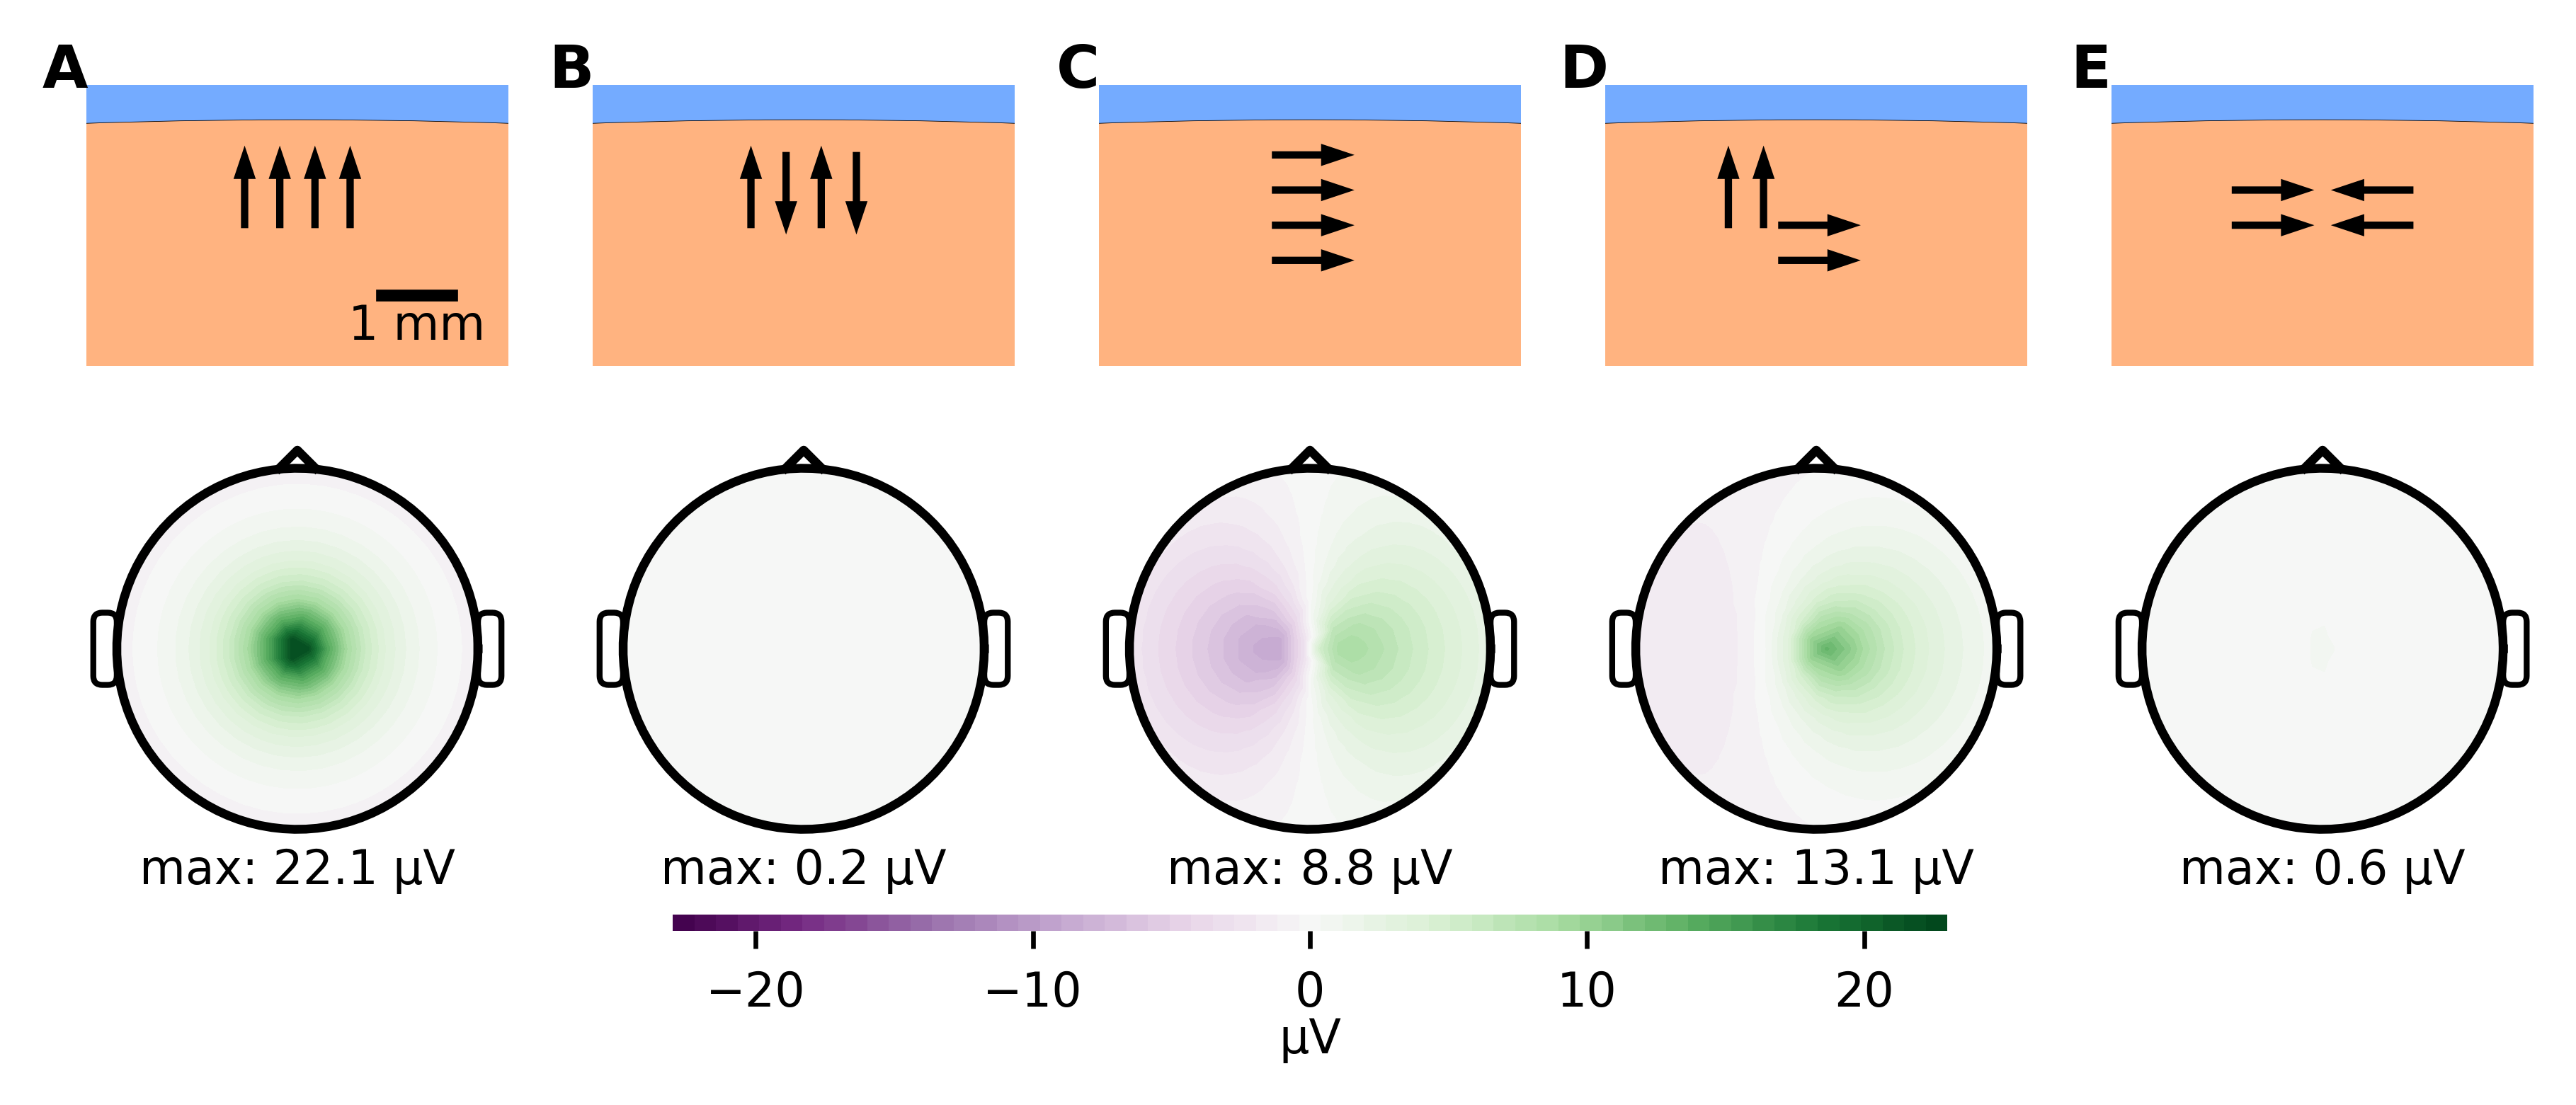

In [20]:
from brainsignals.neural_simulations import return_equidistal_xyz
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

cdm_mag = 1e7
p_rad = np.array([0, 0, cdm_mag])
p_tan = np.array([cdm_mag, 0, 0])

# Manually constructed illustrative combinations of different dipoles 
# at different locations 
ps = [[p_rad, p_rad, p_rad, p_rad],
      [p_rad, -p_rad, p_rad, -p_rad],
      [p_tan, p_tan, p_tan, p_tan],
      [p_rad, p_rad, p_tan, p_tan],
      [p_tan, p_tan, -p_tan, -p_tan]]

loc_z = radii[0] - 1000
p_xs = [[-750, -250, 250, 750],
        [-750, -250, 250, 750],
        [0, 0, 0, 0],
        [-1250, -750, 0, 0],
        [-750, -750, 750, 750]]

p_ys = [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]

p_zs = [[loc_z, loc_z, loc_z, loc_z],
        [loc_z, loc_z, loc_z, loc_z],
        [loc_z + 500, loc_z, loc_z - 500, loc_z - 1000],
        [loc_z, loc_z, loc_z - 500, loc_z - 1000],
        [loc_z, loc_z - 500, loc_z, loc_z - 500]]

num_cases = len(p_xs)
num_dipoles = len(p_xs[0])

x_, y_, z_ = return_equidistal_xyz(1000, radii[-1] - 1) 

upper_idxs = np.where(z_ > 0)
x_ = x_[upper_idxs]
y_ = y_[upper_idxs]
z_ = z_[upper_idxs]

num_elecs = len(x_)
r_elecs = np.vstack((x_, y_, z_)).T

sphere_model = FourSphereVolumeConductor(r_elecs, radii, sigmas)
eeg = np.zeros((num_cases, num_elecs))

for c_idx in range(num_cases):
    for p_idx in range(num_dipoles):
        dipole_loc = np.array([p_xs[c_idx][p_idx], 
                               p_ys[c_idx][p_idx], 
                               p_zs[c_idx][p_idx]])
        p = ps[c_idx][p_idx]
        M = sphere_model.get_transformation_matrix(dipole_loc)  
        eeg[c_idx] += 1e3 * M @ p # (uV)


def plot_four_sphere_model(ax, radii):
    ax.add_patch(plt.Circle((0, 0), radius=radii[1],
                               color=head_colors[1],
                               fill=True, ec='k', lw=.1))
    ax.add_patch(plt.Circle((0, 0), radius=radii[0],
                               color=head_colors[0],
                               fill=True, ec='k', lw=.1))

def plot_head_outline(ax, radius):
    circle_npts = 100
    head_x = radius * np.cos(np.linspace(0, 2 * np.pi, circle_npts))
    head_y = radius * np.sin(np.linspace(0, 2 * np.pi, circle_npts))
    patches = []
    right_ear = mpatches.FancyBboxPatch([radius + 5000, -15000], 3000, 30000,
        boxstyle=mpatches.BoxStyle("Round", pad=5000))
    patches.append(right_ear)

    left_ear = mpatches.FancyBboxPatch([-radius - 8000, -15000], 3000, 30000,
        boxstyle=mpatches.BoxStyle("Round", pad=5000))
    patches.append(left_ear)

    collection = PatchCollection(patches, facecolor='none', edgecolor='k', alpha=1.0)
    ax.add_collection(collection)
    ax.plot(head_x, head_y, 'k')
    ax.plot([radius])

    ax.plot([-10000, 0, 10000], [radius, radius + 10000, radius], 'k')

plt.close("all")
fig = plt.figure()
fig.subplots_adjust(bottom=0.2, right=0.98, left=0.02, 
                    top=0.99, wspace=.2, hspace=0.02)

print(np.max(np.abs(eeg), axis=1))
vmax = 23

levels = np.linspace(-np.ceil(vmax), np.ceil(vmax), 60)

ax_geom_dict = dict(frameon=False, aspect=1,
                     xticks=[], yticks=[],
                     xlim=[-3000, 3000],
                     ylim=[radii[0] - 3500, radii[0] + 500])

ax_eeg_dict = dict(frameon=False, aspect=1,
                   xticks=[], yticks=[],
                   xlim=[-115000, 115000],
                   ylim=[-115000, 115000])

arrow_length = 1000
axes_geom = []
for c_idx in range(num_cases):
    ax_geom = fig.add_subplot(2, num_cases, c_idx + 1, **ax_geom_dict)
    ax_eeg = fig.add_subplot(2, num_cases, c_idx + 1 + num_cases, 
                             **ax_eeg_dict)
    axes_geom.append(ax_geom)
    ax_eeg.text(0, -130000, "max: {:1.1f} µV".format(np.max(np.abs(eeg[c_idx]))),
               ha='center')
    plot_four_sphere_model(ax_geom, radii)
    plot_head_outline(ax_eeg, radii[-1])
    
    for p_idx in range(num_dipoles):
        x0 = p_xs[c_idx][p_idx]
        z0 = p_zs[c_idx][p_idx]
        px = ps[c_idx][p_idx][0]
        pz = ps[c_idx][p_idx][2]
        dx = arrow_length * px / np.abs(px + 1e-1)
        dz = arrow_length * pz  / np.abs(pz + 1e-1)
        
        ax_geom.arrow(x0 - dx/2, z0 - dz/2, dx, dz, width=20, 
                      length_includes_head=True, 
                      head_width=200, fc='k')
        
    img = ax_eeg.tricontourf(x_, y_, eeg[c_idx], levels, cmap=cmap_v_e, 
                             vmax=vmax, vmin=-vmax)
    ax_eeg.tricontour(x_, y_, eeg[c_idx], levels, cmap=cmap_v_e, 
                             vmax=vmax, vmin=-vmax, zorder=-1)
    
    if c_idx == 0:
        ax_geom.plot([1200, 2200], [radii[0]-2500, radii[0]-2500], lw=2, c='k')
        ax_geom.text(1700, radii[0] - 2600, "1 mm", va='top', ha="center")

mark_subplots(axes_geom, ypos=1.05, xpos=-0.05)

cax = fig.add_axes([0.25, 0.13, 0.5, 0.015], frameon=False)
plt.colorbar(img, cax=cax, ticks=[-20, -10, 0, 10, 20], label="µV", orientation="horizontal")

plt.savefig("eeg_dipole_orientation.pdf")

### Tarefa 3: Análise da sensibilidade dos componentes Px, Py e Pz dos dipolos as entradas sinápticas

Para essa parte da prática, nós vamos utilizar o modelo biofisicamente detalhado de um neurônio piramidal da L5 que vimos nos exercícios anteriores e analisar quais as componentes mais afetadas pelas milhares de entradas sinápticas que um neurônio recebe. 

1) Quais as componentes (x, y ou z) são mais afetadas por entradas sinápticas individuais?
2) O que acontece quando o total (soma) das entradas sinápticas? Você conseque explicar por que isso acontece?

In [21]:
from os.path import join
import LFPy
from lfpykit.models import CurrentDipoleMoment
from brainsignals.plotting_convention import mark_subplots
from brainsignals import neural_simulations as ns
import neuron
import os
import sys
from glob import glob
import posixpath

In [22]:
hay_folder = join("L5bPCmodelsEH") 

def return_hay_cell(tstop, dt, make_passive=False):
    if not os.path.isfile(join(hay_folder, 'morphologies', 'cell1.asc')):
        download_hay_model()

    if make_passive:
        cell_params = {
            'morphology': join(hay_folder, 'morphologies', 'cell1.asc'),
            'passive': True,
            'passive_parameters': {"g_pas": 1 / 30000,
                                   "e_pas": -70.},
            'nsegs_method': "lambda_f",
            "Ra": 150,
            "cm": 1.0,
            "lambda_f": 100,
            'dt': dt,
            'tstart': -1,
            'tstop': tstop,
            'v_init': -70,
            'pt3d': True,
        }

        cell = LFPy.Cell(**cell_params)
        cell.set_rotation(x=4.729, y=-3.166)

        return cell
    else:
        if not hasattr(neuron.h, "CaDynamics_E2"):
            neuron.load_mechanisms(join(hay_folder, 'mod'))
        cell_params = {
            'morphology': join(hay_folder, "morphologies", "cell1.asc"),
            'templatefile': [join(hay_folder, 'models', 'L5PCbiophys3.hoc'),
                             join(hay_folder, 'models', 'L5PCtemplate.hoc')],
            'templatename': 'L5PCtemplate',
            'templateargs': join(hay_folder, 'morphologies', 'cell1.asc'),
            'passive': False,
            'nsegs_method': None,
            'dt': dt,
            'tstart': -200,
            'tstop': tstop,
            'v_init': -75,
            'celsius': 34,
            'pt3d': True,
        }

        cell = LFPy.TemplateCell(**cell_params)

        cell.set_rotation(x=4.729, y=-3.166)
        return cell

In [23]:
np.random.seed(1234)
dt = 2**-4
tstop = 20

# Define synapse parameters
synapse_params = {
    'e' : 0.,                   # reversal potential
    'syntype' : 'Exp2Syn',       # synapse type
    'tau1' : 0.1,                 # synaptic time constant
    'tau2' : 1.,                 # synaptic time constant
    'weight' : 0.001,            # synaptic weight
    'record_current' : False,    # record synapse current
}
neuron.load_mechanisms("L5bPCmodelsEH/mod/")
cell = return_hay_cell(tstop, dt, make_passive=True)

# Store for plotting
cell_x, cell_z = cell.x.copy(), cell.z.copy()
synidxs = cell.get_rand_idx_area_norm(z_min=-1e9, z_max=300, nidx=100)
del cell

In [29]:
cdms = []
tvec = None
for s_, synidx in enumerate(synidxs):
    if s_ % 10 == 0:
        print(s_ + 1, "/", len(synidxs))
    cell = return_hay_cell(tstop, dt, make_passive=True)

    synapse_params["idx"] = synidx
    synapse = LFPy.Synapse(cell, **synapse_params)
    synapse.set_spike_times(np.array([1.]))

    cell.simulate(rec_imem=True, rec_vmem=True)
    cdm = CurrentDipoleMoment(cell).get_transformation_matrix() @ cell.imem
    cdms.append(cdm.copy())
    if s_ == 0:
        tvec = cell.tvec.copy()
    del cell
    del synapse
    del cdm

# Now doing simultaneous input
cell = return_hay_cell(tstop, dt, make_passive=True)
for s_, synidx in enumerate(synidxs):
    synapse_params["idx"] = synidx
    synapse = LFPy.Synapse(cell, **synapse_params)
    synapse.set_spike_times(np.array([1.]))

cell.simulate(rec_imem=True, rec_vmem=True)
cdms_sum = CurrentDipoleMoment(cell).get_transformation_matrix() @ cell.imem

cdm_max = 3 #np.max(np.abs(cdms)) * 0.75
cdm_sum_max = 60 #np.max(np.abs(cdms_sum)) * 0.75


1 / 100
11 / 100
21 / 100
31 / 100
41 / 100
51 / 100
61 / 100
71 / 100
81 / 100
91 / 100


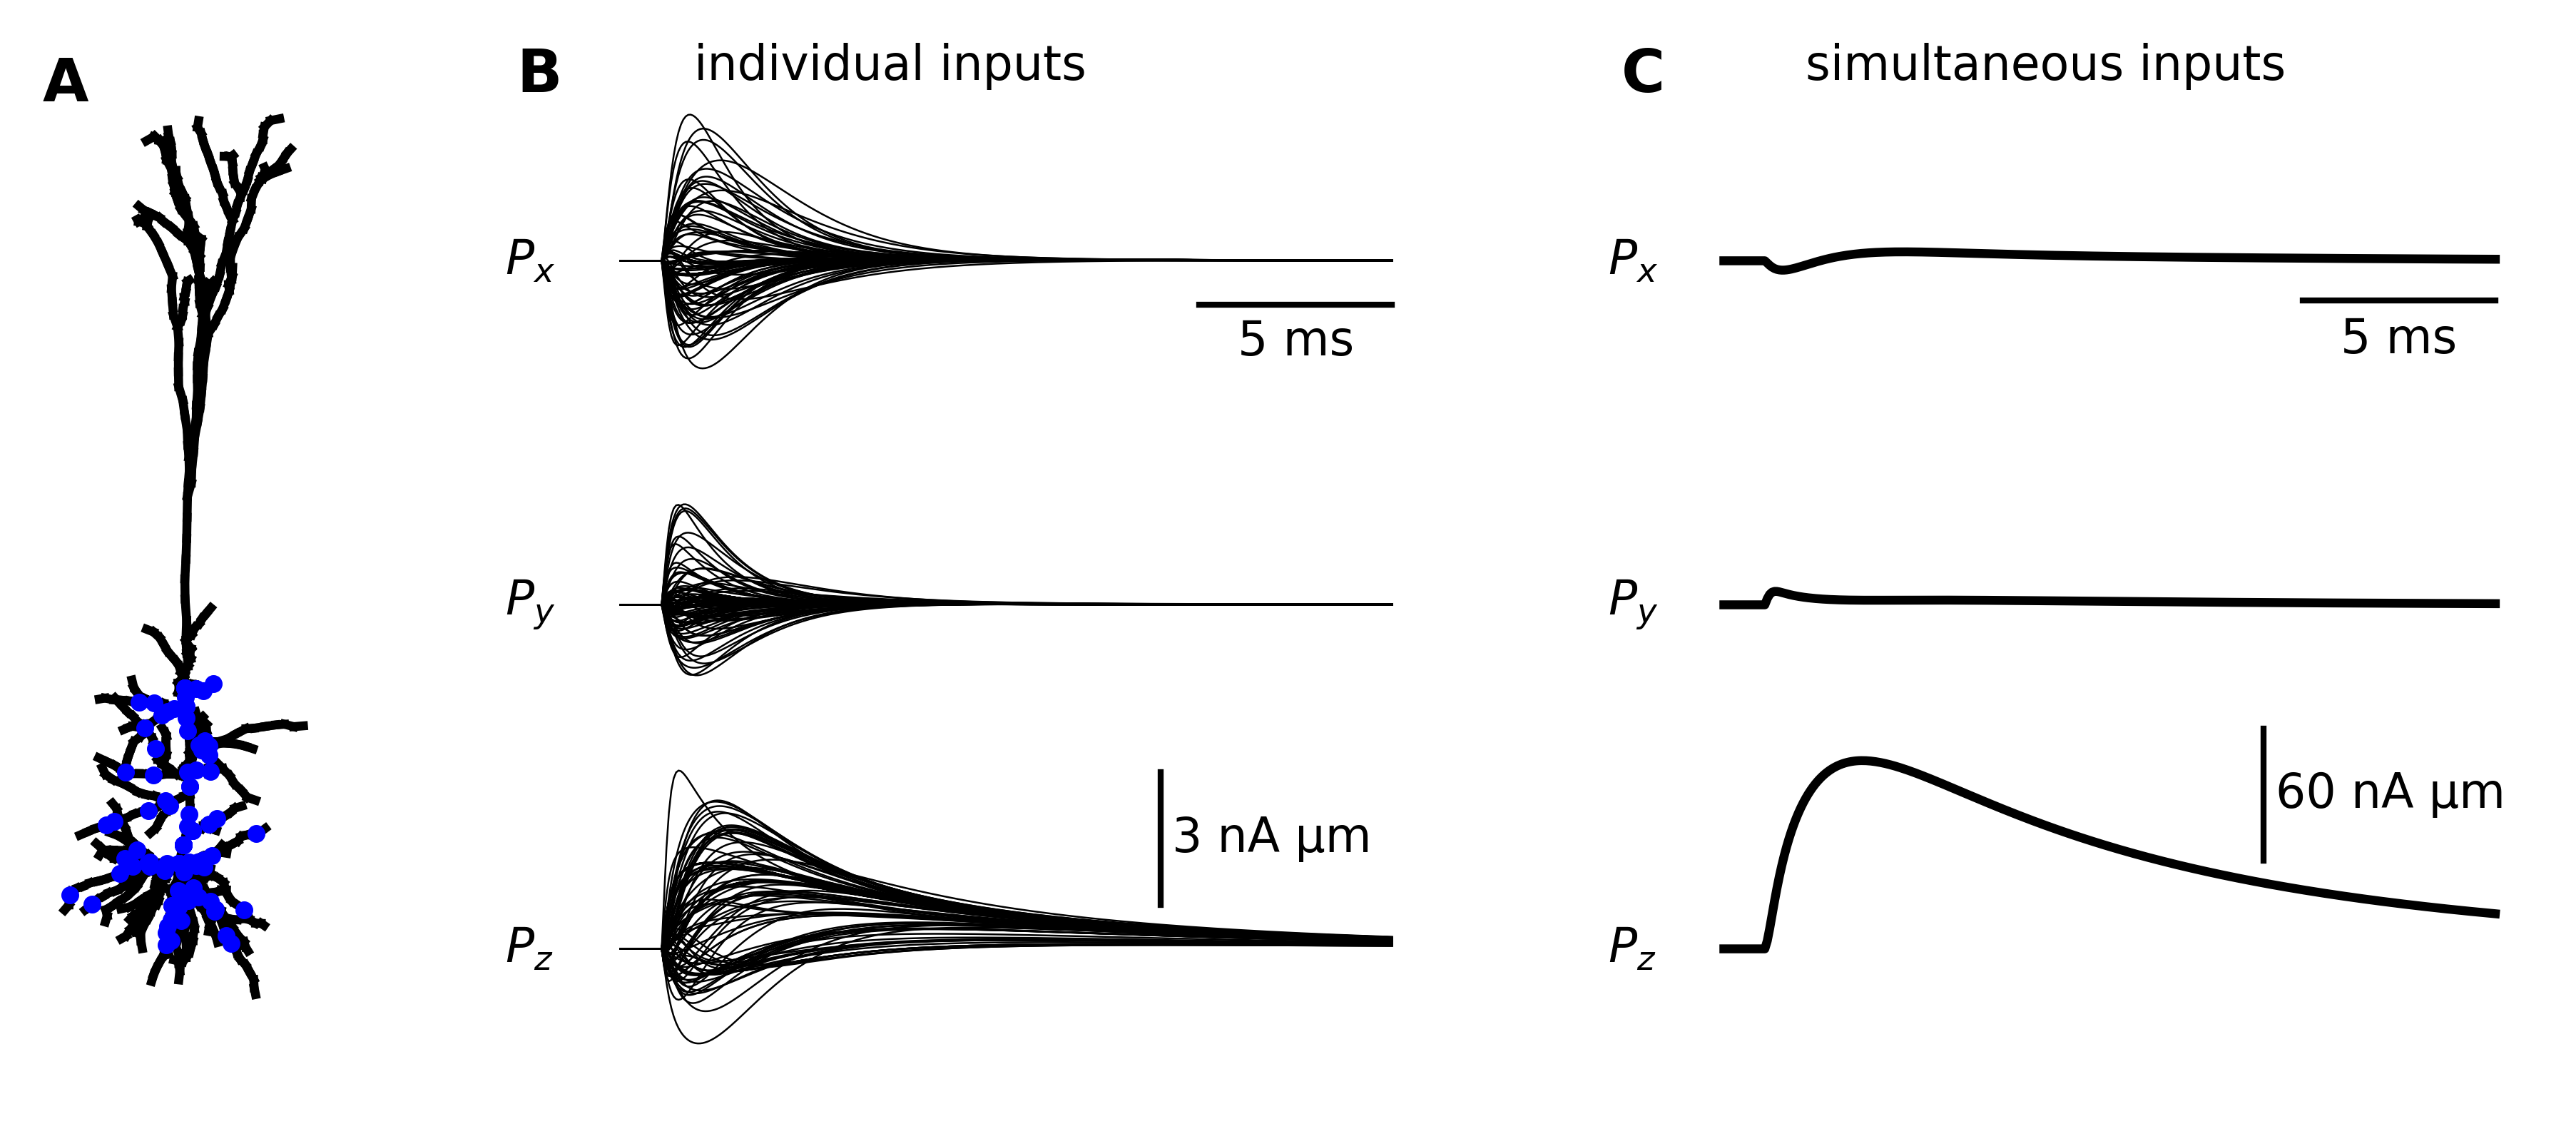

In [30]:
fig = plt.figure()
fig.subplots_adjust(bottom=0.01, top=0.9, right=0.99, left=0.23,
                    wspace=0.3, hspace=0.3,)
ax0 = fig.add_axes([0.0, 0.05, 0.15, 0.9], aspect=1,
                   frameon=False, xticks=[], yticks=[])

ax_dict = dict(ylim=[-cdm_max, cdm_max],
               frameon=False, xticks=[], yticks=[])
ax_ind_1 = fig.add_subplot(321, **ax_dict)
ax_ind_2 = fig.add_subplot(323, **ax_dict)
ax_ind_3 = fig.add_subplot(325, **ax_dict)

ax_dict = dict(ylim=[-cdm_sum_max, cdm_sum_max],
               frameon=False, xticks=[], yticks=[])
ax_sum_1 = fig.add_subplot(322, **ax_dict)
ax_sum_2 = fig.add_subplot(324, **ax_dict)
ax_sum_3 = fig.add_subplot(326, **ax_dict)

ax_ind_1.text(-3, 0, "$P_x$", va="center")
ax_ind_2.text(-3, 0, "$P_y$", va="center")
ax_ind_3.text(-3, 0, "$P_z$", va="center")

ax_sum_1.text(-3, 0, "$P_x$", va="center")
ax_sum_2.text(-3, 0, "$P_y$", va="center")
ax_sum_3.text(-3, 0, "$P_z$", va="center")

fig.text(0.35, 0.98, "individual inputs", ha="center", va="top")
fig.text(0.8, 0.98, "simultaneous inputs", ha="center", va="top")

ax0.plot(cell_x.T, cell_z.T, c='k')
ax0.plot(cell_x[synidxs].mean(axis=1), cell_z[synidxs].mean(axis=1), 'o',
         ms=2, c='b')

ax_ind_3.plot([tstop - 6, tstop - 6], [1, 1+cdm_max], clip_on=False, c='k', lw=1)
ax_ind_3.text(tstop - 5.7, 1 + cdm_max/2, "{:d} nA µm".format(int(cdm_max)),
              ha='left', va="center")

ax_sum_3.plot([tstop - 6, tstop - 6], [40, 40+cdm_sum_max], clip_on=False, c='k', lw=1)
ax_sum_3.text(tstop - 5.7, 40 + cdm_sum_max/2, "{:d} nA µm".format(int(cdm_sum_max)),
              ha='left', va="center")

ax_ind_1.plot([tstop - 5, tstop], [-1, -1], c='k', lw=1)
ax_ind_1.text(tstop - 2.5, -1.3, "5 ms", ha="center", va="top")

ax_sum_1.plot([tstop - 5, tstop], [-18, -18], c='k', lw=1)
ax_sum_1.text(tstop - 2.5, -25, "5 ms", ha="center", va="top")

for s_, synidx in enumerate(synidxs):
    ax_ind_1.plot(tvec, cdms[s_][0, :], c='k', clip_on=False, lw=0.3)
    ax_ind_2.plot(tvec, cdms[s_][1, :], c='k', clip_on=False, lw=0.3)
    ax_ind_3.plot(tvec, cdms[s_][2, :], c='k', clip_on=False, lw=0.3)

ax_sum_1.plot(tvec, cdms_sum[0, :], c='k', clip_on=False)
ax_sum_2.plot(tvec, cdms_sum[1, :], c='k', clip_on=False)
ax_sum_3.plot(tvec, cdms_sum[2, :], c='k', clip_on=False)

mark_subplots(ax0, "A", xpos=0.05, ypos=.99)
mark_subplots(ax_ind_1, "B", xpos=-0.05, ypos=1.2)
mark_subplots(ax_sum_1, "C", xpos=-0.05, ypos=1.2)

plt.savefig("pz_remains.pdf")

### Tarefa 4: Comparação do efeito da distribuição espacial de sinapses em sinais extracelulares de EEG e de LFP

**Para pensar:**

1) Antes de rodar a simualação, responda: o que você acredita que será mais sensível a variação da distribuição de sinapses?


**Exercícios:**

2) Explique qual o efeito da variação da distribuição de entradas sinápticas ao longo de um único neurônio no sinal de LFP e no sinal de EEG.

3) A sua hipótese sobre a sensibilidade dos potenciais extracelulares se confirmou? Por que você acredita que isso acontece?

4) Pense sobre as implicações do resultado observado para uma rede de múltiplos neurônios. 

Mechanisms already loaded from path: L5bPCmodelsEH/mod/.  Aborting.


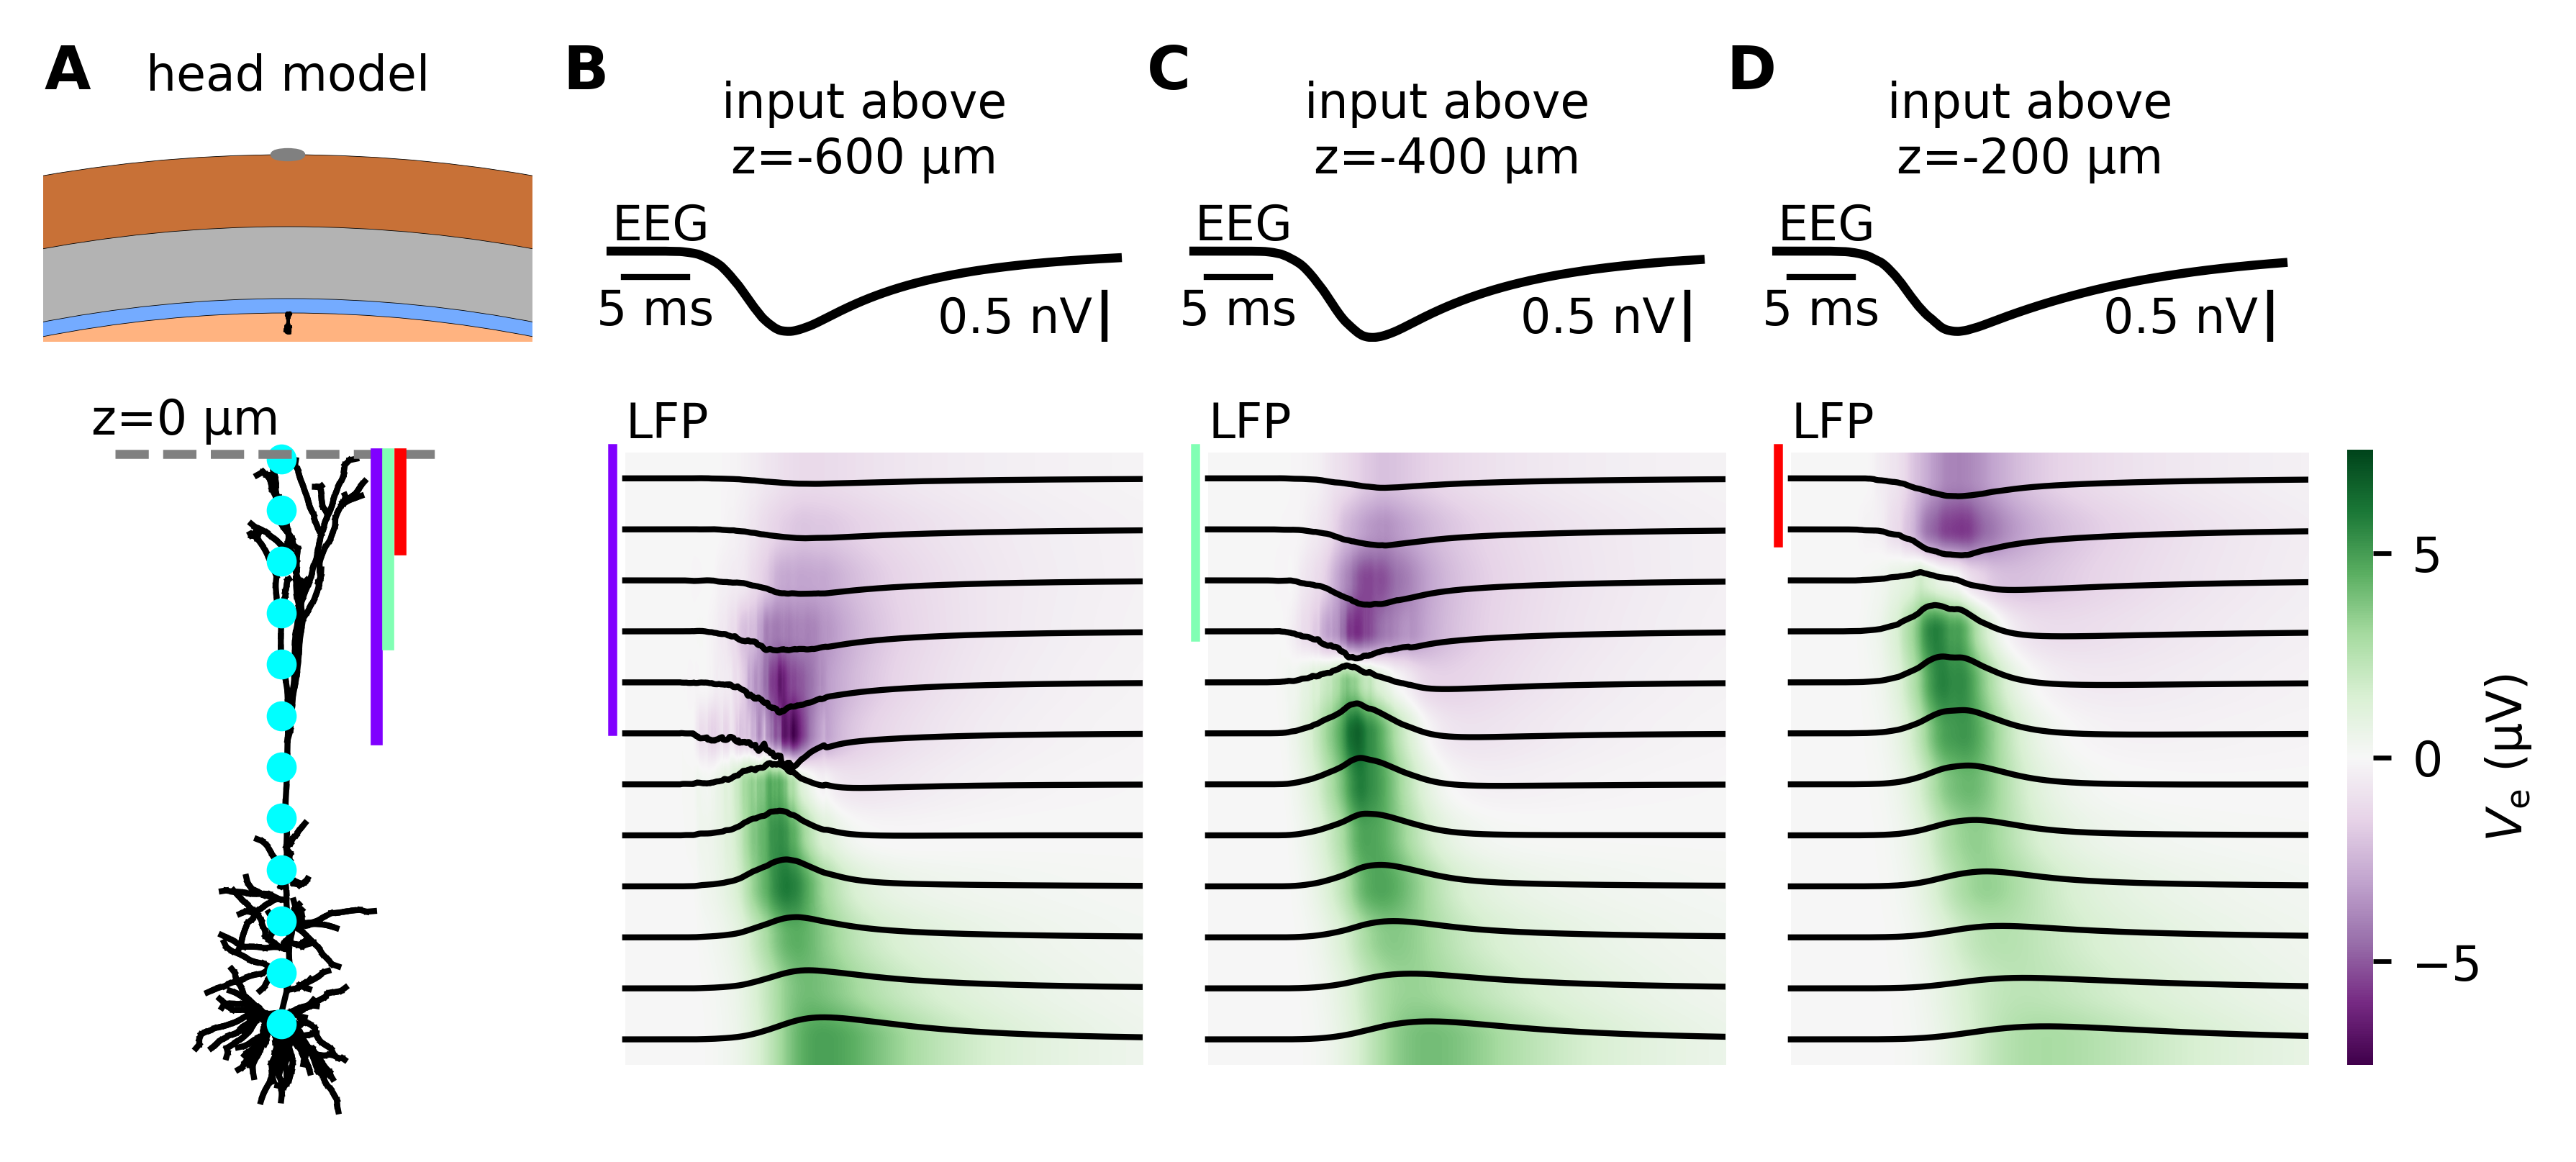

In [34]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import neuron
import LFPy
from brainsignals.plotting_convention import mark_subplots, cmap_v_e
import brainsignals.neural_simulations as ns
import os
import sys
from os.path import join
from glob import glob
import posixpath

ns.load_mechs_from_folder(ns.cell_models_folder)

head_colors = ["#ffb380", "#74abff", "#b3b3b3", "#c87137"]
radii = np.array([89000., 90000., 95000., 100000.])  # (µm)
sigmas = [0.276, 1.65, 0.01, 0.465]  # (S/m)

rad_tol = 1e-2
sigma = 0.3
num_elecs = 12
# Define electrode parameters
elec_params = {
    'sigma': sigma,      # extracellular conductivity
    'x': np.zeros(num_elecs),  # electrode positions
    'y': np.zeros(num_elecs),
    'z': np.linspace(-1200, -10, num_elecs),
    'method': 'root_as_point'
}
dz = np.abs(elec_params["z"][1] - elec_params["z"][0])

synapse_params = {
    'syntype' : 'ExpSynI',      # current-based exponential synapse
    'tau' : 1.,                #Time constant, rise
    'weight' : 0.005,           #Synaptic weight
    'record_current' : False,    #record synaptic currents
}


hay_folder = join("L5bPCmodelsEH") 

neuron.load_mechanisms("L5bPCmodelsEH/mod/")

def return_hay_cell(tstop, dt, make_passive=False):
    if not os.path.isfile(join(hay_folder, 'morphologies', 'cell1.asc')):
        download_hay_model()

    if make_passive:
        cell_params = {
            'morphology': join(hay_folder, 'morphologies', 'cell1.asc'),
            'passive': True,
            'passive_parameters': {"g_pas": 1 / 30000,
                                   "e_pas": -70.},
            'nsegs_method': "lambda_f",
            "Ra": 150,
            "cm": 1.0,
            "lambda_f": 100,
            'dt': dt,
            'tstart': -1,
            'tstop': tstop,
            'v_init': -70,
            'pt3d': True,
        }

        cell = LFPy.Cell(**cell_params)
        cell.set_rotation(x=4.729, y=-3.166)

        return cell
    else:
        if not hasattr(neuron.h, "CaDynamics_E2"):
            neuron.load_mechanisms(join(hay_folder, 'mod'))
        cell_params = {
            'morphology': join(hay_folder, "morphologies", "cell1.asc"),
            'templatefile': [join(hay_folder, 'models', 'L5PCbiophys3.hoc'),
                             join(hay_folder, 'models', 'L5PCtemplate.hoc')],
            'templatename': 'L5PCtemplate',
            'templateargs': join(hay_folder, 'morphologies', 'cell1.asc'),
            'passive': False,
            'nsegs_method': None,
            'dt': dt,
            'tstart': -200,
            'tstop': tstop,
            'v_init': -75,
            'celsius': 34,
            'pt3d': True,
        }

        cell = LFPy.TemplateCell(**cell_params)

        cell.set_rotation(x=4.729, y=-3.166)
        return cell

def insert_synapses(cell, synapse_params, z_min,  spiketimes):
    """ Find n compartments to insert synapses onto """
    n = len(spiketimes)
    idx = cell.get_rand_idx_area_norm(section="allsec", nidx=n, z_min=z_min)
    for i in idx:
        synapse_params.update({'idx' : int(i)})
        s = LFPy.Synapse(cell, **synapse_params)
        s.set_spike_times(np.array([spiketimes[i]]))


def plot_four_sphere_model(ax, radii):
    for i in range(4):
        ax.add_patch(plt.Circle((0, 0), radius=radii[-1 - i],
                                   color=head_colors[-1-i],
                                   fill=True, ec='k', lw=.1))
    ax.add_patch(Ellipse((0, radii[-1]), 2000, 500, color='gray'))


def plot_laminar_lfp(lfp, ax, tvec, normalize):
    z = elec_params["z"]
    dz = np.abs(z[1] - z[0])
    lfp_ = lfp / normalize
    for elec in range(lfp.shape[0]):
        ax.plot(tvec, lfp_[elec] * dz / 1.5 + z[elec], c='k', lw=1)
    img = ax.imshow(lfp, cmap=cmap_v_e, origin="lower",
                    vmax=normalize, vmin=-normalize,
                    extent=[0, tvec[-1], np.min(z) - dz/2, np.max(z) + dz/2])
    ax.axis("auto")
    return img

num_syns = 1000
input_t_center = 10
input_t_std = 2
tstop = 40
dt = 2**-4
tvec = np.arange(tstop / dt + 1) * dt

z_mins = np.array([-600, -400, -200])

num_trials = 10
seeds = np.random.randint(1, 124121, num_trials)
lfp_dict = {}
eeg_dict = {}

for i, z_min in enumerate(z_mins):
    eeg_trial = []
    lfp_trial = []

    for trial, seed in enumerate(seeds):
        np.random.seed(seed)
        spiketimes = np.random.normal(input_t_center, input_t_std, size=num_syns)
        cell = return_hay_cell(tstop=tstop, dt=dt, make_passive=True)
        cell.set_pos(z=-np.max(cell.z) - 10)
        insert_synapses(cell, synapse_params, z_min, spiketimes)
        cell.simulate(rec_imem=True, rec_vmem=True)

        electrode = LFPy.RecExtElectrode(cell, **elec_params)
        electrode.LFP = electrode.get_transformation_matrix() @ cell.imem

        somapos = np.array([0., 0., radii[0] + cell.z[0].mean()])
        r_soma_syns = [cell.get_intersegment_vector(idx0=0, idx1=i)
                       for i in cell.synidx]
        r_mid = np.average(r_soma_syns, axis=0)
        r_mid = somapos + r_mid/2.

        eeg_coords_top = np.array([[0., 0., radii[-1] - rad_tol]])

        four_sphere_top = LFPy.FourSphereVolumeConductor(eeg_coords_top,
                                                         radii, sigmas)
        cdm = LFPy.CurrentDipoleMoment(cell).get_transformation_matrix() @ cell.imem

        pot_db_4s_top = four_sphere_top.get_transformation_matrix(r_mid) @ cdm

        eeg_trial.append(np.array(pot_db_4s_top)[0] * 1e6)
        lfp_trial.append(electrode.LFP * 1000)

        del cell
        del electrode
    eeg_dict[z_min] = np.sum(eeg_trial, axis=0)
    lfp_dict[z_min] = np.sum(lfp_trial, axis=0)



depth_clrs = {z_min: plt.cm.rainbow(i / (len(z_mins) - 1))
              for i, z_min in enumerate(z_mins)}

ax_h_eeg = 0.1
ax_h_lfp = 0.6
ax_lfp_hstart = 0.05
ax_eeg_hstart = 0.72
ax_w = 0.215
ax_wspace = 0.01
ax_left = 0.0

plt.close("all")
fig = plt.figure()

ax_grid_lfp = [ax_left, 0, ax_w, 0.66]
ax_morph = fig.add_axes(ax_grid_lfp, frameon=False, aspect=1,
                        xticks=[], yticks=[], xlim=[-350, 350],
                        ylim=[-1400, 100])

ax_grid_4s = [0.01, ax_eeg_hstart, 0.2, 0.2]
ax_4s = fig.add_axes(ax_grid_4s, frameon=False, aspect=1,
                     xticks=[], yticks=[],
                     xlim=[-17000, 17000],
                     ylim=[87000, 102000])
ax_4s.set_title("head model")
plot_four_sphere_model(ax_4s, radii)

ax_morph.plot(elec_params["x"], elec_params["z"], 'o',
              c='cyan', ms=4, zorder=1)
ax_morph.axhline(0, c='gray', ls="--")
ax_morph.text(-400, 20, "z=0 µm", va="bottom")

cell = return_hay_cell(tstop=tstop, dt=dt, make_passive=True)
cell.set_pos(z=-np.max(cell.z) - 10)

for idx in range(cell.totnsegs):
    ax_morph.plot(cell.x[idx],  cell.z[idx], c='k', lw=1, zorder=-1)
    ax_4s.plot(cell.x[idx], cell.z[idx] + radii[0],
            c='k', lw=0.5)
cell.__del__()

lfp_normalize = np.max([np.max(np.abs(lfp)) for lfp in lfp_dict.values()])
eeg_normalize = np.max([np.max(np.abs(eeg)) for eeg in eeg_dict.values()])

ax_lfp_dict = dict(ylim=[-1350, 50],
                   frameon=False, xticks=[], yticks=[])
ax_eeg_dict = dict(frameon=False, xticks=[], yticks=[],
                   ylim=[-eeg_normalize * 1.05, eeg_normalize/5])

img = None
for i, z_min in enumerate(z_mins):

    ax_grid_lfp = [ax_left + (i + 1) * (ax_w + ax_wspace),
               ax_lfp_hstart, ax_w, ax_h_lfp]
    ax_grid_eeg = [ax_left + (i + 1) * (ax_w + ax_wspace),
               ax_eeg_hstart, ax_w, ax_h_eeg]

    ax_lfp = fig.add_axes(ax_grid_lfp, **ax_lfp_dict)
    ax_eeg = fig.add_axes(ax_grid_eeg, **ax_eeg_dict)
    ax_eeg.text(0.05, 0.01, "EEG", va="bottom")
    ax_lfp.text(0.05, dz / 2, "LFP", va="bottom")
    ax_eeg.text(tstop/2, 0.75, "input above\nz=%d µm" % z_min, ha='center')
    img = plot_laminar_lfp(lfp_dict[z_min], ax_lfp, tvec, lfp_normalize)
    ax_eeg.plot(tvec, eeg_dict[z_min], c='k')

    ax_morph.plot([200 + i * 25, 200 + i * 25], [0, z_min],
                  lw=2, c=depth_clrs[z_min])
    ax_lfp.plot([-1, -1], [dz/2, z_min + dz/2], c=depth_clrs[z_min])

    ax_eeg.plot([tvec[-1] - 1, tvec[-1] - 1], [-0.4, -0.9], c='k', lw=1)
    ax_eeg.text(tvec[-1] - 2, -0.65, "0.5 nV", va="center", ha="right")

    ax_eeg.plot([1, 6], [-0.25, -0.25], c='k', lw=1)
    ax_eeg.text(3.5, -0.35, "5 ms", va="top", ha="center")
    mark_subplots(ax_eeg, "BCD"[i], ypos=2.5, xpos=0.)

mark_subplots(ax_4s, "A", ypos=1.25, xpos=0.05)

cax = fig.add_axes([0.905, 0.05, 0.01, 0.57], frameon=False)
cbar = fig.colorbar(img, cax=cax)
cbar.set_label(r'$V_{\rm e}$ (µV)', labelpad=0)

fig.savefig("fig_eeg_is_simpler.pdf")

### Tarefa 5: Calculando o sinal de EEG para uma rede de neurônios biofisicamente detalhados

Mechanisms already loaded from path: L5bPCmodelsEH/mod/.  Aborting.


/tmp/ipykernel_28300/1527688221.py:190: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  head_tri = np.array(nyhead.head_data["head"]["tri"]).T - 1 # For 3D plotting
/tmp/ipykernel_28300/1527688221.py:191: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  head_vc = np.array(nyhead.head_data["head"]["vc"])
/tmp/ipykernel_28300/1527688221.py:192: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  cortex_tri = np.array(nyhead.head_data["cortex75K"]["tri"]).T - 1 # For 3D plotting


10 8.750498319149546


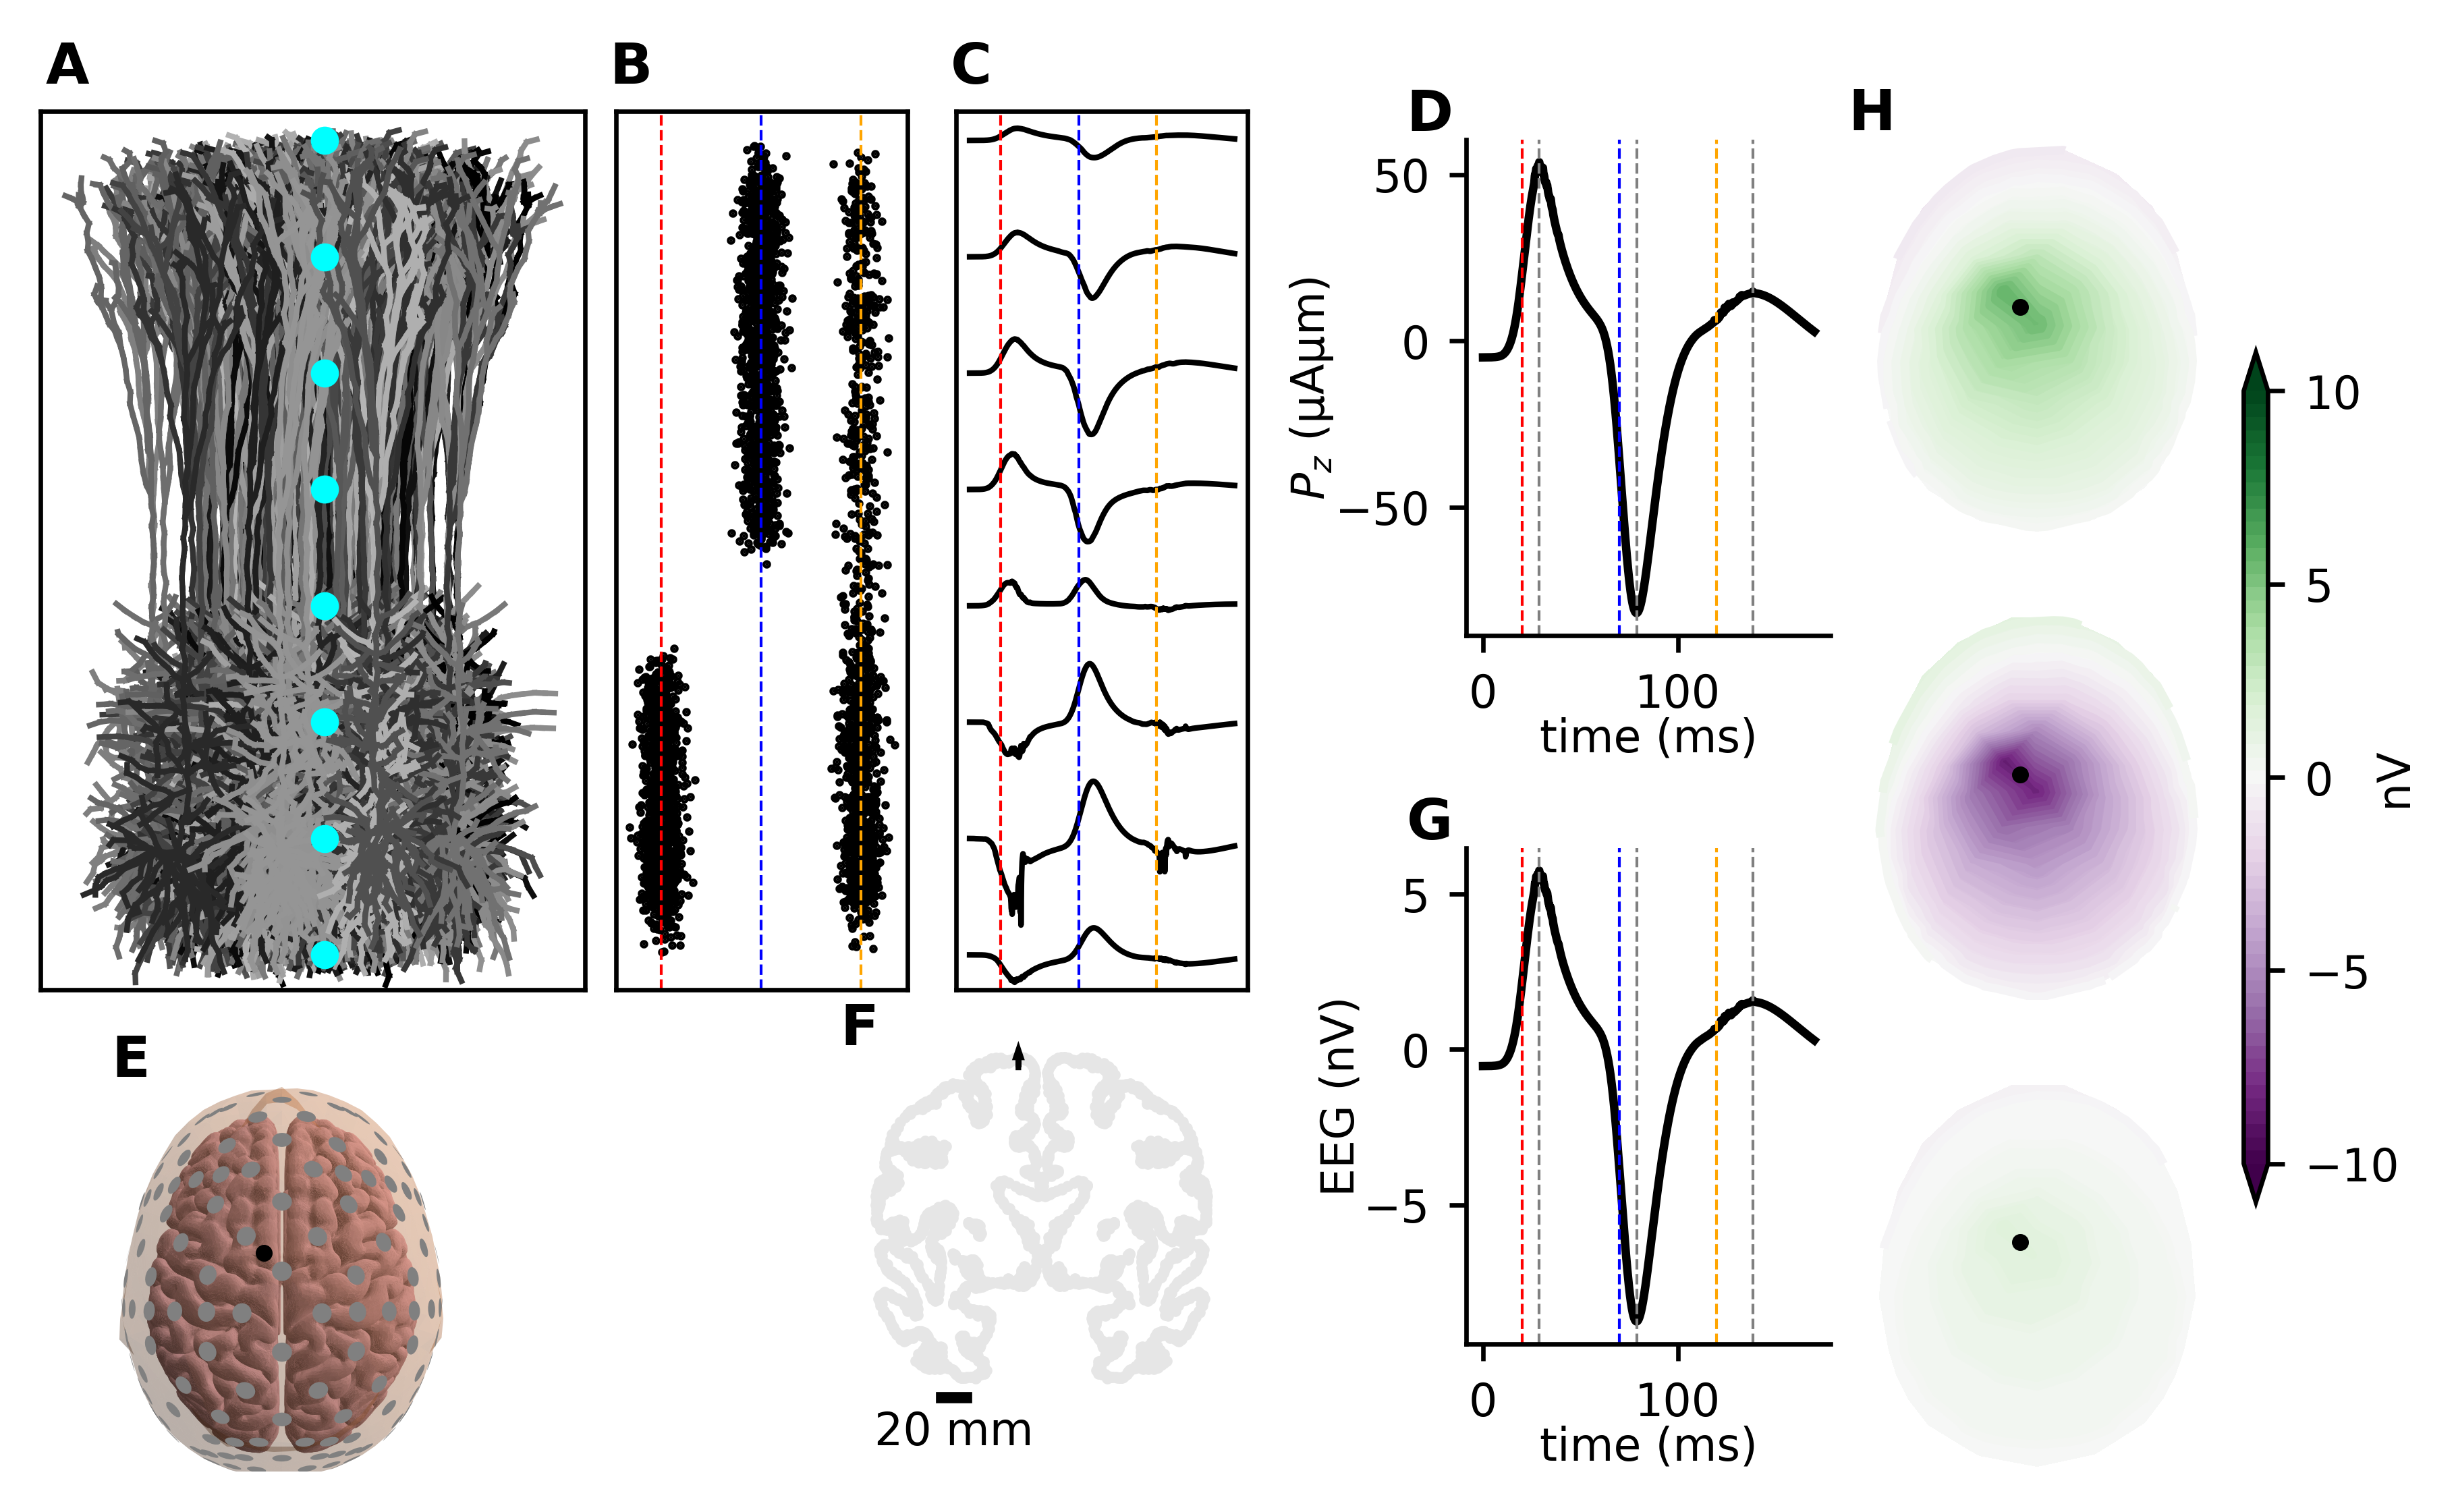

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import elephant
import LFPy
from lfpykit import CurrentDipoleMoment, RecExtElectrode
from lfpykit.eegmegcalc import NYHeadModel
from brainsignals import neural_simulations as ns
from brainsignals.plotting_convention import simplify_axes, mark_subplots, cmap_v_e
import neuron
import os
import sys
from os.path import join
from glob import glob
import posixpath

np.random.seed(1234)

elec_params = {  # parameters for RecExtElectrode class
    'sigma': 0.3,  # Extracellular potential
    'x': np.zeros(8),  # Coordinates of electrode contacts
    'y': np.zeros(8),
    'z': np.linspace(-200, 1200, 8),
}
dz = np.abs(elec_params["z"][1] - elec_params["z"][0])


hay_folder = join("L5bPCmodelsEH") 

def return_hay_cell(tstop, dt, make_passive=False):
    if not os.path.isfile(join(hay_folder, 'morphologies', 'cell1.asc')):
        download_hay_model()

    if make_passive:
        cell_params = {
            'morphology': join(hay_folder, 'morphologies', 'cell1.asc'),
            'passive': True,
            'passive_parameters': {"g_pas": 1 / 30000,
                                   "e_pas": -70.},
            'nsegs_method': "lambda_f",
            "Ra": 150,
            "cm": 1.0,
            "lambda_f": 100,
            'dt': dt,
            'tstart': -1,
            'tstop': tstop,
            'v_init': -70,
            'pt3d': True,
        }

        cell = LFPy.Cell(**cell_params)
        cell.set_rotation(x=4.729, y=-3.166)

        return cell
    else:
        if not hasattr(neuron.h, "CaDynamics_E2"):
            neuron.load_mechanisms(join(hay_folder, 'mod'))
        cell_params = {
            'morphology': join(hay_folder, "morphologies", "cell1.asc"),
            'templatefile': [join(hay_folder, 'models', 'L5PCbiophys3.hoc'),
                             join(hay_folder, 'models', 'L5PCtemplate.hoc')],
            'templatename': 'L5PCtemplate',
            'templateargs': join(hay_folder, 'morphologies', 'cell1.asc'),
            'passive': False,
            'nsegs_method': None,
            'dt': dt,
            'tstart': -200,
            'tstop': tstop,
            'v_init': -75,
            'celsius': 34,
            'pt3d': True,
        }

        cell = LFPy.TemplateCell(**cell_params)

        cell.set_rotation(x=4.729, y=-3.166)
        return cell

neuron.load_mechanisms("L5bPCmodelsEH/mod/")

num_cells = 1000
spike_fraction = 0.05
num_syns = 25
tstop = 170
dt = 2**-4
data_dicts = []

weights = np.ones(num_cells) * 0.001
weights[np.random.random(size=num_cells) < spike_fraction] = 0.002

syn_params = {'e': 0.,
              'record_current': True,
              'syntype': 'Exp2Syn',
              'tau1': 1, 'tau2': 3,
              'idx': 0}

basal_wave = 20
apical_wave = 70
uniform_wave = 120
wave_std = 5


cell = return_hay_cell(tstop=tstop, dt=dt, make_passive=False)

#for cell_id in range(num_cells):
#    cell = return_hay_cell(tstop=tstop, dt=dt, make_passive=False)
#    cell.set_rotation(z=2 * np.pi * np.random.uniform())
#
#    syn_idxs_basal = cell.get_rand_idx_area_norm(nidx=num_syns, z_min=-500, z_max=300)
#    syn_idxs_apical = cell.get_rand_idx_area_norm(nidx=num_syns, z_min=500, z_max=1500)
#    syn_idxs_uniform = cell.get_rand_idx_area_norm(nidx=num_syns, z_min=-500, z_max=1500)
#    
#    cell.set_pos(x=np.random.normal(0, 100),
#                 y=np.random.normal(0, 100),
#                 z=np.random.normal(0, 20),)
#
#    wave_basal = np.random.normal(basal_wave, wave_std, size=num_syns)
#    wave_apical = np.random.normal(apical_wave, wave_std, size=num_syns)
#    wave_uniform = np.random.normal(uniform_wave, wave_std, size=num_syns)
#
#    syn_idxs = np.array([syn_idxs_basal, syn_idxs_apical, syn_idxs_uniform]).flatten()
#    syn_times = np.array([wave_basal, wave_apical, wave_uniform]).flatten()
#
#    for idx, sidx in enumerate(syn_idxs):
#        syn_params["idx"] = sidx
#        syn_params["weight"] = weights[cell_id]
#
#        synapse = LFPy.Synapse(cell, **syn_params)
#        synapse.set_spike_times(np.array([syn_times[idx]]))
#
#    cell.simulate(rec_vmem=True, rec_imem=True)
#
#    cdm = CurrentDipoleMoment(cell)
#    M = cdm.get_transformation_matrix()
#    cdm = M @ cell.imem
#
#    electrode = RecExtElectrode(cell, **elec_params)
#    M = electrode.get_transformation_matrix()
#    V_ex = M @ cell.imem * 1000 # uV
#
#    v = cell.vmem - cell.vmem[:, 0, None]
#
#    data_dicts.append({"cell_x": cell.x.copy(),
#                 "cell_z": cell.z.copy(),
#                 "cell_y": cell.y.copy(),
#                 #"vmem": v,
#                 "tvec": cell.tvec.copy(),
#                 "cdm": cdm.copy(),
#                 "V_ex": V_ex.copy(),
#                 "syn_times": syn_times,
#                 "syn_zs": cell.z[syn_idxs].mean(axis=1),
#                 })
#
#    del cell
#    del synapse
#
#np.save("neural_data_dicts.npy", data_dicts)


data_dicts = np.load("neural_data_dicts.npy", allow_pickle=True)

tvec = data_dicts[0]["tvec"]
num_tsteps = len(tvec)
p = np.zeros((3, num_tsteps))
V_e = np.zeros((8, num_tsteps))
syn_times = []
syn_zs = []
for dd in data_dicts:
    p += dd["cdm"]
    V_e += dd["V_ex"]
    syn_times.extend(dd["syn_times"])
    syn_zs.extend(dd["syn_zs"])

filt_dict_lf = {'highpass_frequency': None,
                 'lowpass_frequency': 300,
                 'order': 4,
                 'filter_function': 'filtfilt',
                 'sampling_frequency': 1 / dt * 1000,
                 'axis': -1}

V_e_lf = elephant.signal_processing.butter(V_e, **filt_dict_lf)
    


dipole_loc = np.array([-9.17467219,  0.09118176, 75.61421356]) # x, y, z location in mm
nyhead = NYHeadModel()

cortex = nyhead.cortex # Locations of every vertex in cortex
elecs = np.array(nyhead.elecs) # 3D locations of electrodes

head_tri = np.array(nyhead.head_data["head"]["tri"]).T - 1 # For 3D plotting
head_vc = np.array(nyhead.head_data["head"]["vc"])
cortex_tri = np.array(nyhead.head_data["cortex75K"]["tri"]).T - 1 # For 3D plotting
x_ctx, y_ctx, z_ctx = cortex
x_h, y_h, z_h = head_vc[0, :], head_vc[1, :], head_vc[2, :]
num_elecs = elecs.shape[1]

upper_idxs = np.where(elecs[2, :] > 0)[0]
elecs = elecs[:, upper_idxs]
nyhead.set_dipole_pos(dipole_loc)

# We rotate current dipole moment to be oriented along the normal vector of cortex
p = nyhead.rotate_dipole_to_surface_normal(p)

vertex_idx = np.argmin(np.sqrt(np.sum((dipole_loc[:, None] - cortex)**2, axis=0)))
p -= np.mean(p, axis=1)[:, None]

# Calculate EEG signal from lead field. 
eeg = np.zeros((num_elecs, num_tsteps))
eeg[:, :] = nyhead.get_transformation_matrix() @ p * 1e6  # nV

eeg = eeg[upper_idxs, :]

# Find closest electrode
top_elec_idx = np.argmin(np.sqrt(np.sum((cortex[:, vertex_idx, None] - 
                       elecs[:3, :])**2, axis=0)))
max_time_idx = np.argmax(np.abs(eeg[top_elec_idx]))

from mpl_toolkits.mplot3d import art3d
from matplotlib.patches import Circle
def rotation_matrix(d):
    """
    Calculates a rotation matrix given a vector d. The direction of d
    corresponds to the rotation axis. The length of d corresponds to
    the sin of the angle of rotation.

    Variant of: http://mail.scipy.org/pipermail/numpy-discussion/2009-March/040806.html
    """
    sin_angle = np.linalg.norm(d)

    if sin_angle == 0:
        return np.identity(3)

    d /= sin_angle

    eye = np.eye(3)
    ddt = np.outer(d, d)
    skew = np.array([[    0,  d[2],  -d[1]],
                  [-d[2],     0,  d[0]],
                  [d[1], -d[0],    0]], dtype=np.float64)

    M = ddt + np.sqrt(1 - sin_angle**2) * (eye - ddt) + sin_angle * skew
    return M

def pathpatch_2d_to_3d(pathpatch, z=0, normal='z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str: #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1.0,0,0), index)

    normal /= np.linalg.norm(normal) #Make sure the vector is normalised

    path = pathpatch.get_path() #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path) #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D #Change the class
    pathpatch._code3d = path.codes #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color

    verts = path.vertices #Get the vertices in 2D

    d = np.cross(normal, (0, 0, 1)) #Obtain the rotation vector
    M = rotation_matrix(d) #Get the rotation matrix

    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])

def pathpatch_translate(pathpatch, delta):
    """
    Translates the 3D pathpatch by the amount delta.
    """
    pathpatch._segment3d += delta


# The rest is just plotting
plt.close("all")
fig = plt.figure(figsize=[6, 3.5])
fig.subplots_adjust(bottom=0.17, right=0.93, left=0.01, 
                    top=0.9, wspace=.1, hspace=0.6)

# Plot 3D head
ax_head = fig.add_axes([.01, 0.01, 0.2, 0.3], projection='3d',
                          xticks=[], yticks=[], zticks=[],
                          xlim=[-70, 70], facecolor="none",
                          ylim=[-70, 70], zlim=[-70, 70], rasterized=True,
                          computed_zorder=False,
                          )

ax_geom = fig.add_axes([0.35, 0.05, 0.15, 0.27], aspect=1, 
                       frameon=False, 
                      xticks=[], yticks=[], rasterized=True)

ax_neur = fig.add_axes([0.0, 0.35, 0.25, 0.62], xticks=[], yticks=[],
                             aspect=1,
                      ylim=[-260, 1250], rasterized=True)

ax_syn = fig.add_axes([0.25, 0.35, 0.12, 0.62], xticks=[], yticks=[],
                      ylim=[-260, 1250], rasterized=True)

ax_ecp = fig.add_axes([0.39, 0.35, 0.12, 0.62], xticks=[], yticks=[],
                      ylim=[-260, 1250])

ax_p = fig.add_axes([0.6, 0.6, 0.15, 0.35], xlabel="time (ms)", ylabel="$P_z$ (µAµm)")
ax_eeg1 = fig.add_axes([0.6, 0.1, 0.15, 0.35], xlabel="time (ms)", ylabel="EEG (nV)")

ax_eeg_b = fig.add_axes([0.75, 0.66, 0.17, 0.33], xlim=[-110, 110], 
                       ylim=[-120, 110], aspect=1, 
                       frameon=False, rasterized=True, 
                      xticks=[], yticks=[])
ax_eeg_a = fig.add_axes([0.75, 0.33, 0.17, 0.33], xlim=[-110, 110], 
                       ylim=[-120, 110], aspect=1,
                       frameon=False, rasterized=True, 
                      xticks=[], yticks=[])
ax_eeg_u = fig.add_axes([0.75, 0.0, 0.17, 0.33], xlim=[-110, 110], 
                       ylim=[-120, 110], aspect=1, 
                       frameon=False, rasterized=True, 
                      xticks=[], yticks=[])

ax_head.axis('off')
ax_head.plot_trisurf(x_ctx, y_ctx, z_ctx, triangles=cortex_tri,
                              color="pink", zorder=0, rasterized=True)

ax_head.plot_trisurf(x_h, y_h, z_h, triangles=head_tri, 
                     color="#c87137", zorder=0, alpha=0.2)
all_patches = []                     
for elec_idx in range(len(elecs[0, :])):
    elec_normal = elecs[3:, elec_idx]
    elec_xyz = elecs[:3, elec_idx]
    p_ = Circle((0, 0), 5, facecolor='gray', zorder=elec_xyz[2],
               ) #Add a circle in the xy plane
    all_patches.append(p_)
    ax_head.add_patch(p_)
    pathpatch_2d_to_3d(p_, z=0, normal=elec_normal)
    pathpatch_translate(p_, elec_xyz)

ax_head.view_init(elev=90., azim=-90)
fig.text(0.05, 0.3, "E",
                horizontalalignment='center',
                verticalalignment='center',
                fontweight='demibold',
                fontsize=10)
ax_p.plot(tvec, 1e-3 * p[2, :], c='k')
ax_eeg1.plot(tvec, eeg[top_elec_idx], c='k')

ax_syn.scatter(syn_times[::20], syn_zs[::20], marker=".", s=1, color='k')


max_V_e = 300
norm = 1 / max_V_e * dz

for elec in range(len(V_e)):
    v_ecp = (V_e[elec] - V_e[elec, 0]) * norm + elec_params["z"][elec]
    ax_ecp.plot(tvec, v_ecp, c='k', lw=1)

t_idx_b = np.argmin(np.abs(basal_wave - tvec))
t_idx_a = np.argmin(np.abs(apical_wave - tvec))
t_idx_u = np.argmin(np.abs(uniform_wave - tvec))

t_idx_bmax = np.argmax(eeg[top_elec_idx, :])
t_idx_amax = np.argmin(eeg[top_elec_idx, :])
t_idx_umax = np.argmax(eeg[top_elec_idx, t_idx_u:]) + t_idx_u

l_ecp = ax_ecp.axvline(basal_wave, ls="--", c='r', lw=0.5)
l_syn = ax_syn.axvline(basal_wave, ls="--", c='r', lw=0.5)

l_ecp = ax_ecp.axvline(apical_wave, ls="--", c='b', lw=0.5)
l_syn = ax_syn.axvline(apical_wave, ls="--", c='b', lw=0.5)

l_ecp = ax_ecp.axvline(uniform_wave, ls="--", c='orange', lw=0.5)
l_syn = ax_syn.axvline(uniform_wave, ls="--", c='orange', lw=0.5)

ax_p.axvline(basal_wave, ls="--", c='r', lw=0.5)
ax_eeg1.axvline(basal_wave, ls="--", c='r', lw=0.5)

ax_p.axvline(tvec[t_idx_bmax], ls="--", c='gray', lw=0.5)
ax_eeg1.axvline(tvec[t_idx_bmax], ls="--", c='gray', lw=0.5)
ax_p.axvline(tvec[t_idx_amax], ls="--", c='gray', lw=0.5)
ax_eeg1.axvline(tvec[t_idx_amax], ls="--", c='gray', lw=0.5)
ax_p.axvline(tvec[t_idx_umax], ls="--", c='gray', lw=0.5)
ax_eeg1.axvline(tvec[t_idx_umax], ls="--", c='gray', lw=0.5)

ax_p.axvline(apical_wave, ls="--", c='b', lw=0.5)
ax_eeg1.axvline(apical_wave, ls="--", c='b', lw=0.5)

l_p = ax_p.axvline(uniform_wave, ls="--", c='orange', lw=0.5)
l_eeg = ax_eeg1.axvline(uniform_wave, ls="--", c='orange', lw=0.5)


cax = fig.add_axes([0.92, 0.2, 0.01, 0.6]) # This axis is just the colorbar

vmax = 10#np.floor(np.max(np.abs(eeg[:, max_time_idx])))
print(vmax, np.max(np.abs(eeg[:, max_time_idx])))


vmap = lambda v: cmap_v_e((v + vmax) / (2*vmax))
levels = np.linspace(-vmax, vmax, 60)

contourf_kwargs = dict(levels=levels, 
                       cmap=cmap_v_e, 
                       vmax=vmax, 
                       vmin=-vmax,
                      extend="both")

# Plot 3D location EEG electrodes
img = ax_eeg_b.tricontourf(elecs[0], elecs[1], eeg[:, t_idx_bmax], **contourf_kwargs)
ax_eeg_b.tricontour(elecs[0], elecs[1], eeg[:, t_idx_bmax], **contourf_kwargs)

img = ax_eeg_a.tricontourf(elecs[0], elecs[1], eeg[:, t_idx_amax], **contourf_kwargs)
ax_eeg_a.tricontour(elecs[0], elecs[1], eeg[:, t_idx_amax], **contourf_kwargs)

img = ax_eeg_u.tricontourf(elecs[0], elecs[1], eeg[:, t_idx_umax], **contourf_kwargs)
ax_eeg_u.tricontour(elecs[0], elecs[1], eeg[:, t_idx_umax], **contourf_kwargs)

cbar = plt.colorbar(img, cax=cax)
cbar.set_label("nV", labelpad=-5)
cbar.set_ticks([-vmax, -vmax/2, 0, vmax/2, vmax])


# Plotting crossection of cortex around active region center
threshold = 2  # threshold in mm for including points in plot
xz_plane_idxs = np.where(np.abs(cortex[1, :] - 
                                dipole_loc[1]) < threshold)[0]

ax_geom.scatter(cortex[0, xz_plane_idxs], 
            cortex[2, xz_plane_idxs], s=1, c='0.9')

ax_geom.plot([-30, -40], [-60, -60], c='k', lw=2)
ax_geom.text(-35, -65, "20 mm", ha='center', va="top")
ax_geom.arrow(cortex[0, vertex_idx], cortex[2, vertex_idx] - 4, 0, 4, 
          color='k', head_width=2)
        
ax_eeg_b.plot(cortex[0, vertex_idx], cortex[1, vertex_idx], 'o', c='k', ms=2)
ax_eeg_a.plot(cortex[0, vertex_idx], cortex[1, vertex_idx], 'o', c='k', ms=2)
ax_eeg_u.plot(cortex[0, vertex_idx], cortex[1, vertex_idx], 'o', c='k', ms=2)
ax_head.plot(cortex[0, vertex_idx], cortex[1, vertex_idx], cortex[2, vertex_idx], 'o', c='k', ms=2)


num_plot_cells = 300
clrfunc_cells = lambda c_idx: plt.cm.Greys(0.4 + c_idx / num_plot_cells * 0.6)
for cell_idx in range(num_plot_cells):
    dd = data_dicts[cell_idx]
    
    ax_neur.plot(dd["cell_x"].T, dd["cell_z"].T,
                          c=clrfunc_cells(cell_idx), lw=1.,
                          zorder=dd["cell_y"].mean())

ax_neur.plot(elec_params["x"], elec_params["z"], 'o', c="cyan", ms=4, 
             zorder=1000)

mark_subplots([ax_neur, ax_syn, ax_ecp], "ABC", ypos=1.05, xpos=0.05)

simplify_axes([ax_p, ax_eeg1])
mark_subplots([ax_geom], "F", ypos=1.01, xpos=0.0)
mark_subplots([ax_eeg_b], "H", ypos=0.97, xpos=0.1)
mark_subplots([ax_p, ax_eeg1], "DG", ypos=1.05, xpos=-0.1)
plt.savefig("EEG_waves_illustration.pdf")

## REFERÊNCIAS

Halnes G, Ness TV, Næss S, Hagen E, Pettersen KH, Einevoll GT. Electric Brain Signals: Foundations and Applications of Biophysical Modeling. Cambridge University Press; 2024.